In [78]:
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [79]:
merged = pd.read_parquet('merged_eth_usdt_vwap_oct2025.parquet', engine = 'pyarrow')
merged.dropna(inplace = True)
merged

,dex_price,cex_price
timestamp,,
1759276800000,4147.802786,4145.285621
1759276803000,4143.787639,4145.339682
1759276806000,4143.689566,4146.557793
1759276809000,4148.503567,4146.364820
1759276812000,4148.289107,4146.678950
...,...,...
1761954255000,3858.177483,3857.259093
1761954267000,3858.239828,3857.645999
1761954306000,3858.445123,3858.569559


In [80]:
# Ensure index is sorted and in datetime format
merged.sort_index(inplace=True)
if not isinstance(merged.index, pd.DatetimeIndex):
    merged.index = pd.to_datetime(merged.index, unit='ms')

# Create TimeSeries objects
# We set fill_missing_dates=True and freq='3S' to handle potential gaps in the data
ts_dex = TimeSeries.from_dataframe(merged, value_cols='dex_price', fill_missing_dates=True, freq='3S')
ts_cex = TimeSeries.from_dataframe(merged, value_cols='cex_price', fill_missing_dates=True, freq='3S')

/opt/anaconda3/lib/python3.12/site-packages/darts/timeseries.py:5145: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled_times = resampled_times.asfreq(freq)
/opt/anaconda3/lib/python3.12/site-packages/darts/timeseries.py:5145: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled_times = resampled_times.asfreq(freq)


In [81]:
# Prepare data for analysis
# We use the TimeSeries objects to ensure we have a regular frequency (filled gaps)
# Convert back to pandas for statsmodels
df_dex = ts_dex.to_dataframe()
df_cex = ts_cex.to_dataframe()
df_filled = pd.concat([df_dex, df_cex], axis=1)
# Fill any NaNs introduced by filling missing dates (using forward fill for prices)
df_filled.ffill(inplace=True)
df_filled.dropna(inplace=True)

In [82]:
df_filled

,dex_price,cex_price
timestamp,,
2025-10-01 00:00:00,4147.802786,4145.285621
2025-10-01 00:00:03,4143.787639,4145.339682
2025-10-01 00:00:06,4143.689566,4146.557793
2025-10-01 00:00:09,4148.503567,4146.364820
2025-10-01 00:00:12,4148.289107,4146.678950
...,...,...
2025-10-31 23:45:27,3858.445123,3858.569559
2025-10-31 23:45:30,3858.445123,3858.569559
2025-10-31 23:45:33,3858.445123,3858.569559


In [83]:
df_filled.index = df_filled.index.tz_localize('UTC')
df_filled

,dex_price,cex_price
timestamp,,
2025-10-01 00:00:00+00:00,4147.802786,4145.285621
2025-10-01 00:00:03+00:00,4143.787639,4145.339682
2025-10-01 00:00:06+00:00,4143.689566,4146.557793
2025-10-01 00:00:09+00:00,4148.503567,4146.364820
2025-10-01 00:00:12+00:00,4148.289107,4146.678950
...,...,...
2025-10-31 23:45:27+00:00,3858.445123,3858.569559
2025-10-31 23:45:30+00:00,3858.445123,3858.569559
2025-10-31 23:45:33+00:00,3858.445123,3858.569559


In [84]:
gas_df = pd.read_csv("eth_blocks_2025_10.csv", parse_dates=["timestamp"])
gas_df.set_index("timestamp", inplace=True)
gas_df

,block,base_fee_gwei,gas_used_ratio
timestamp,,,
2025-10-01 00:00:11+00:00,23479244,0.170842,0.828981
2025-10-01 00:00:23+00:00,23479245,0.184893,0.681497
2025-10-01 00:00:35+00:00,23479246,0.193282,0.459371
2025-10-01 00:00:47+00:00,23479247,0.191319,0.460847
2025-10-01 00:00:59+00:00,23479248,0.189446,0.550238
...,...,...,...
2025-10-30 23:59:11+00:00,23693624,0.107225,0.523330
2025-10-30 23:59:23+00:00,23693625,0.107851,0.366043
2025-10-30 23:59:35+00:00,23693626,0.104239,0.519415


In [85]:
gas_3s = gas_df.resample("3S").ffill()
df_with_gas = df_filled.join(gas_3s, how="left").ffill()
df_with_gas.dropna(inplace=True)
df_with_gas

/var/folders/5w/tld6r38s2xg4_3yjmhmggv980000gn/T/ipykernel_57958/1141186062.py:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  gas_3s = gas_df.resample("3S").ffill()


,dex_price,cex_price,block,base_fee_gwei,gas_used_ratio
timestamp,,,,,
2025-10-01 00:00:12+00:00,4148.289107,4146.678950,23479244.0,0.170842,0.828981
2025-10-01 00:00:15+00:00,4149.004069,4147.120565,23479244.0,0.170842,0.828981
2025-10-01 00:00:18+00:00,4150.025145,4146.967599,23479244.0,0.170842,0.828981
2025-10-01 00:00:21+00:00,4149.712129,4146.757055,23479244.0,0.170842,0.828981
2025-10-01 00:00:24+00:00,4146.727186,4146.727621,23479245.0,0.184893,0.681497
...,...,...,...,...,...
2025-10-31 23:45:27+00:00,3858.445123,3858.569559,23693627.0,0.104745,0.415229
2025-10-31 23:45:30+00:00,3858.445123,3858.569559,23693627.0,0.104745,0.415229
2025-10-31 23:45:33+00:00,3858.445123,3858.569559,23693627.0,0.104745,0.415229


In [105]:
q = df_with_gas['base_fee_gwei'].quantile([0.25, 0.5, 0.75, 0.9])

low_gas   = df_with_gas[df_with_gas['base_fee_gwei'] <= q[0.25]]
med_gas   = df_with_gas[(df_with_gas['base_fee_gwei'] > q[0.25]) & (df_with_gas['base_fee_gwei'] <= q[0.75])]
high_gas  = df_with_gas[df_with_gas['base_fee_gwei'] >= q[0.9]]

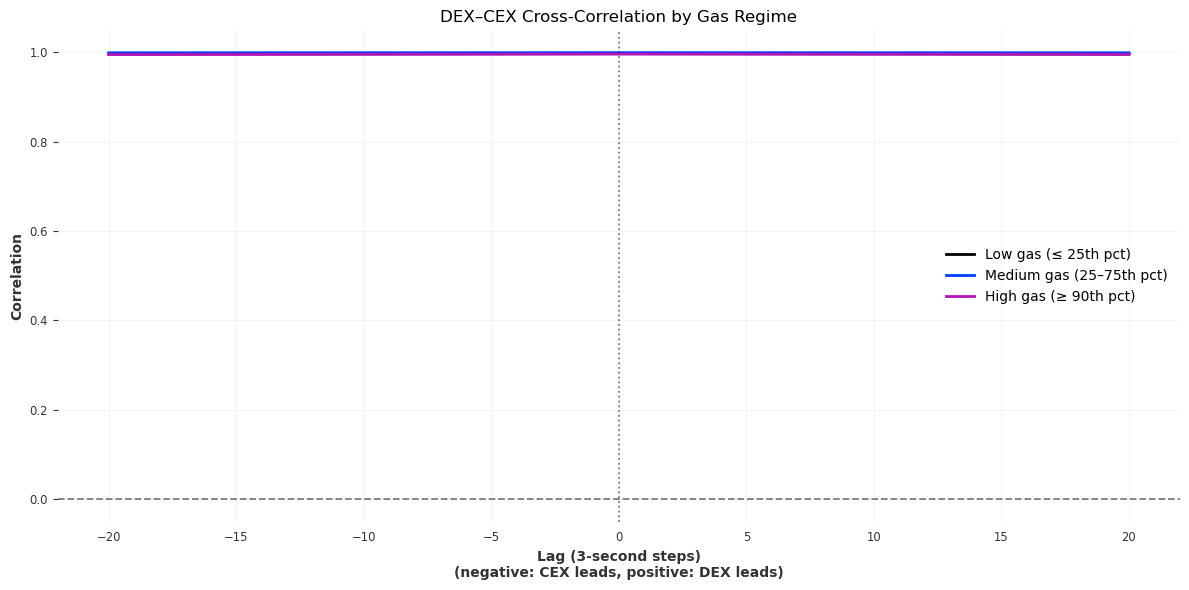

Peak lag (low gas):    0
Peak corr (low gas):   0.9972653405636553
Peak lag (med gas):    0
Peak corr (med gas):   0.9995412773296024
Peak lag (high gas):   0
Peak corr (high gas):  0.9963974507095437


In [107]:
def cross_corr_plot(df):
    lags = range(-20,21)
    corrs = [df['dex_price'].corr(df['cex_price'].shift(l)) for l in lags]
    return lags, corrs

lags_h, corrs_h = cross_corr_plot(high_gas)
lags_m, corrs_m = cross_corr_plot(med_gas)
lags_l, corrs_l = cross_corr_plot(low_gas)

lags_h = np.array(list(lags_h))
lags_l = np.array(list(lags_l))
lags_m = np.array(list(lags_m))

plt.figure(figsize=(12, 6))

plt.plot(lags_l, corrs_l, label='Low gas (≤ 25th pct)', linewidth=2)
plt.plot(lags_m, corrs_m, label='Medium gas (25–75th pct)', linewidth=2)
plt.plot(lags_h, corrs_h, label='High gas (≥ 90th pct)', linewidth=2)

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(0, color='black', linestyle=':', alpha=0.5)

plt.xlabel('Lag (3-second steps)\n(negative: CEX leads, positive: DEX leads)')
plt.ylabel('Correlation')
plt.title('DEX–CEX Cross-Correlation by Gas Regime')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: print where each regime’s peak is
print("Peak lag (low gas):   ", lags_l[np.nanargmax(corrs_l)])
print("Peak corr (low gas):  ", np.nanmax(corrs_l))
print("Peak lag (med gas):   ", lags_m[np.nanargmax(corrs_m)])
print("Peak corr (med gas):  ", np.nanmax(corrs_m))
print("Peak lag (high gas):  ", lags_h[np.nanargmax(corrs_h)])
print("Peak corr (high gas): ", np.nanmax(corrs_h))


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


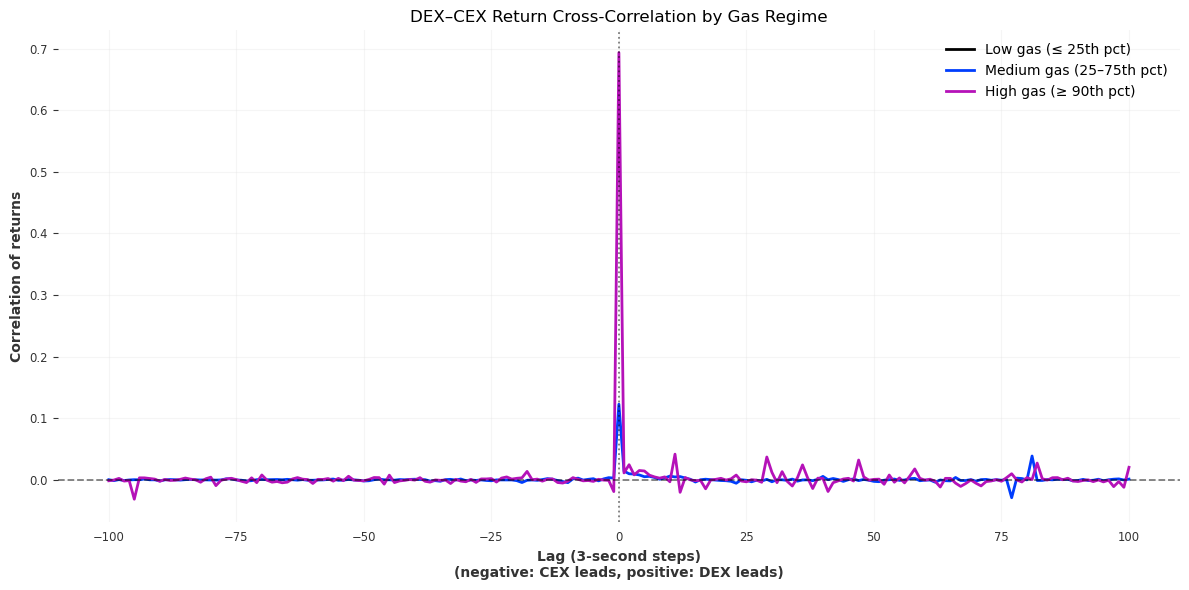

Low gas: all correlations NaN (no usable variation in this regime)
Med gas: peak lag = 0, peak corr = 0.12271351590730242
High gas: peak lag = 0, peak corr = 0.6932778042230903


In [112]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Build returns dataframe aligned with gas
df_ret = df_with_gas[['dex_price', 'cex_price', 'base_fee_gwei']].copy()
df_ret['dex_ret'] = df_ret['dex_price'].pct_change()
df_ret['cex_ret'] = df_ret['cex_price'].pct_change()
df_ret = df_ret.dropna(subset=['dex_ret', 'cex_ret'])  # drop first row

# 2. Define gas regimes on *this* frame
q = df_ret['base_fee_gwei'].quantile([0.25, 0.5, 0.75, 0.9])

low_gas  = df_ret[df_ret['base_fee_gwei'] <= q[0.25]]
med_gas  = df_ret[(df_ret['base_fee_gwei'] > q[0.25]) & (df_ret['base_fee_gwei'] <= q[0.75])]
high_gas = df_ret[df_ret['base_fee_gwei'] >= q[0.9]]

def cross_corr_ret(df, max_lag=20, min_obs=50):
    lags = range(-max_lag, max_lag + 1)
    corrs = []
    for l in lags:
        x = df['dex_ret']
        y = df['cex_ret'].shift(l)

        valid = x.notna() & y.notna()
        if valid.sum() < min_obs:
            corrs.append(np.nan)
            continue

        xv = x[valid]
        yv = y[valid]

        # if either series is (almost) constant, corr is undefined → NaN
        if xv.std() == 0 or yv.std() == 0:
            corrs.append(np.nan)
        else:
            corrs.append(xv.corr(yv))

    return np.array(list(lags)), np.array(corrs)

lags_l, corrs_l = cross_corr_ret(low_gas)
lags_m, corrs_m = cross_corr_ret(med_gas)
lags_h, corrs_h = cross_corr_ret(high_gas)

# 3. Plot
plt.figure(figsize=(12, 6))

plt.plot(lags_l, corrs_l, label='Low gas (≤ 25th pct)', linewidth=2)
plt.plot(lags_m, corrs_m, label='Medium gas (25–75th pct)', linewidth=2)
plt.plot(lags_h, corrs_h, label='High gas (≥ 90th pct)', linewidth=2)

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(0, color='black', linestyle=':', alpha=0.5)

plt.xlabel('Lag (3-second steps)\n(negative: CEX leads, positive: DEX leads)')
plt.ylabel('Correlation of returns')
plt.title('DEX–CEX Return Cross-Correlation by Gas Regime')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

def print_peak(label, lags, corrs):
    if np.all(np.isnan(corrs)):
        print(f"{label}: all correlations NaN (no usable variation in this regime)")
    else:
        i = np.nanargmax(corrs)
        print(f"{label}: peak lag = {lags[i]}, peak corr = {corrs[i]}")

print_peak("Low gas",  lags_l, corrs_l)
print_peak("Med gas",  lags_m, corrs_m)
print_peak("High gas", lags_h, corrs_h)


In [113]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

# 1. Build returns dataframe aligned with gas
df_ret = df_with_gas[['dex_price', 'cex_price', 'base_fee_gwei']].copy()
df_ret['dex_ret'] = df_ret['dex_price'].pct_change()
df_ret['cex_ret'] = df_ret['cex_price'].pct_change()
df_ret = df_ret.dropna(subset=['dex_ret', 'cex_ret'])  # drop first row

# 2. Define gas regimes on *this* frame
q = df_ret['base_fee_gwei'].quantile([0.25, 0.5, 0.75, 0.9])

low_gas  = df_ret[df_ret['base_fee_gwei'] <= q[0.25]]
med_gas  = df_ret[(df_ret['base_fee_gwei'] > q[0.25]) & (df_ret['base_fee_gwei'] <= q[0.75])]
high_gas = df_ret[df_ret['base_fee_gwei'] >= q[0.9]]

print("Sizes:")
print("low_gas :", len(low_gas))
print("med_gas :", len(med_gas))
print("high_gas:", len(high_gas))


Sizes:
low_gas : 221881
med_gas : 443753
high_gas: 88752


In [118]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_pvalues(df, max_lag=10, direction="cex_to_dex"):
    """
    direction:
        "cex_to_dex": does CEX cause DEX?  target=dex_ret, predictor=cex_ret
        "dex_to_cex": does DEX cause CEX?  target=cex_ret, predictor=dex_ret
    returns: lags, pvals (F-test p-values for ssr_ftest), or all-NaN if unusable
    """

    # If there's no finite data at all, bail
    if (not np.isfinite(df['dex_ret']).any()) or (not np.isfinite(df['cex_ret']).any()):
        return np.arange(1, max_lag+1), np.full(max_lag, np.nan)

    # Choose column order for statsmodels
    if direction == "cex_to_dex":
        data = df[['dex_ret', 'cex_ret']].copy()
    else:  # "dex_to_cex"
        data = df[['cex_ret', 'dex_ret']].copy()

    # Clean NaN / inf
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    # Need enough observations
    if len(data) < max_lag + 5:
        return np.arange(1, max_lag+1), np.full(max_lag, np.nan)

    # If any series is constant, Granger is meaningless
    if data.iloc[:,0].std() == 0 or data.iloc[:,1].std() == 0:
        return np.arange(1, max_lag+1), np.full(max_lag, np.nan)

    # Run test
    res = grangercausalitytests(data, maxlag=max_lag, verbose=False)

    lags = []
    pvals = []
    for lag, info in res.items():
        # info is a tuple: (test_dict, [reg_results,...])
        test_dict = info[0]
        ftest = test_dict['ssr_ftest']  # (F-stat, p-value, df_denom, df_num)
        pval = ftest[1]
        lags.append(lag)
        pvals.append(pval)

    return np.array(lags), np.array(pvals)



=== Granger:  Low gas (≤ 25th pct)  ===
std(dex_ret) = nan  std(cex_ret) = 0.00012821413351534505


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


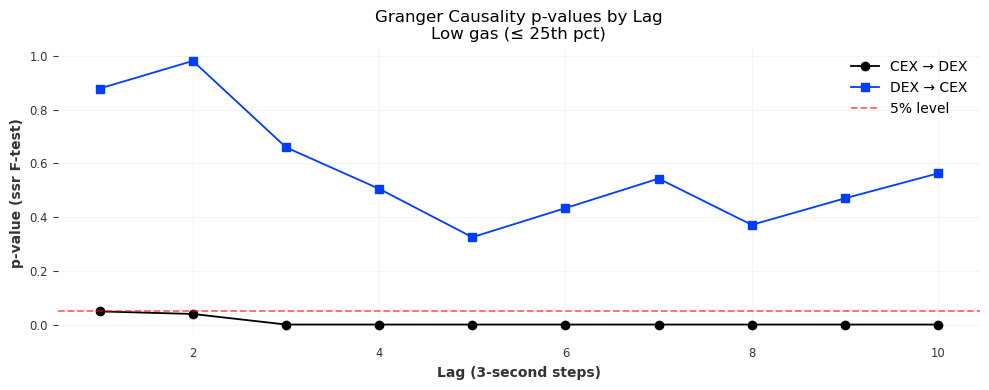

  CEX → DEX significant at lags: [ 1  2  3  4  5  6  7  8  9 10]
  DEX → CEX significant at lags: []

=== Granger:  Med gas (25–75th pct)  ===
std(dex_ret) = 0.0009926690708694766  std(cex_ret) = 0.00016454102200112665


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


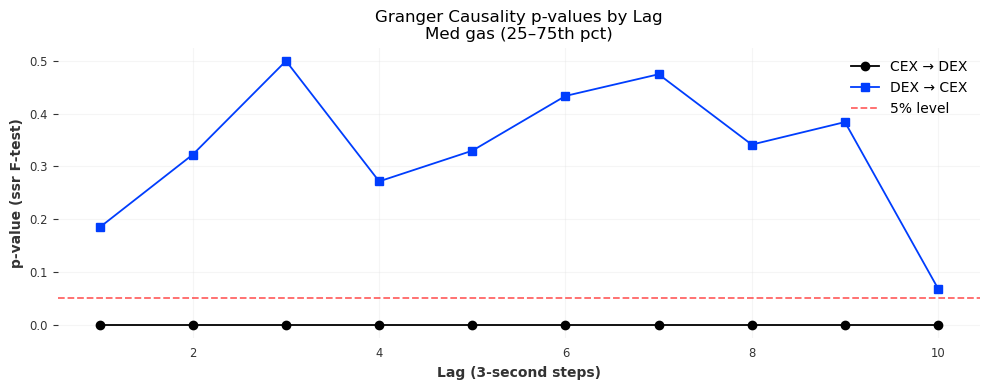

  CEX → DEX significant at lags: [ 1  2  3  4  5  6  7  8  9 10]
  DEX → CEX significant at lags: []

=== Granger:  High gas (≥ 90th pct)  ===
std(dex_ret) = 0.0008725856963635887  std(cex_ret) = 0.0005486056809281396


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


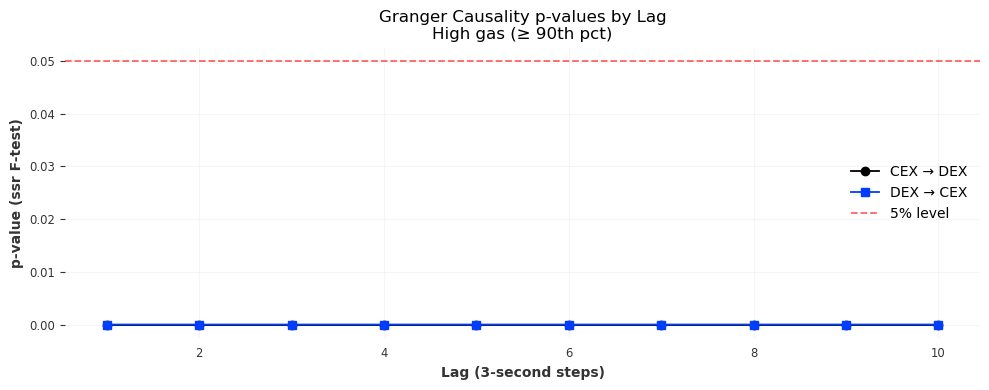

  CEX → DEX significant at lags: [ 1  2  3  4  5  6  7  8  9 10]
  DEX → CEX significant at lags: [ 1  2  3  4  5  6  7  8  9 10]


In [120]:
max_lag = 10

regimes = {
    "Low gas (≤ 25th pct)"  : low_gas,
    "Med gas (25–75th pct)" : med_gas,
    "High gas (≥ 90th pct)" : high_gas,
}

for name, df_reg in regimes.items():
    print("\n=== Granger: ", name, " ===")
    print("std(dex_ret) =", df_reg['dex_ret'].std(), 
          " std(cex_ret) =", df_reg['cex_ret'].std())

    # CEX -> DEX
    lags1, pvals1 = granger_pvalues(df_reg, max_lag=max_lag, direction="cex_to_dex")
    # DEX -> CEX
    lags2, pvals2 = granger_pvalues(df_reg, max_lag=max_lag, direction="dex_to_cex")

    plt.figure(figsize=(10,4))
    plt.plot(lags1, pvals1, marker='o', label='CEX → DEX')
    plt.plot(lags2, pvals2, marker='s', label='DEX → CEX')
    plt.axhline(0.05, color='red', linestyle='--', alpha=0.6, label='5% level')

    plt.xlabel('Lag (3-second steps)')
    plt.ylabel('p-value (ssr F-test)')
    plt.title(f'Granger Causality p-values by Lag\n{name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    if not np.all(np.isnan(pvals1)):
        sig_lags1 = lags1[pvals1 < 0.05]
        print("  CEX → DEX significant at lags:", sig_lags1)
    else:
        print("  CEX → DEX: no usable variation / all NaN")

    if not np.all(np.isnan(pvals2)):
        sig_lags2 = lags2[pvals2 < 0.05]
        print("  DEX → CEX significant at lags:", sig_lags2)
    else:
        print("  DEX → CEX: no usable variation / all NaN")


Low gas:
- CEX returns clearly help predict DEX returns.
- DEX returns do not help predict CEX returns.
- Lead–lag exists.
- The direction is CEX → DEX.

Gas is cheap → on-chain arbitrage is frictionless → DEX mechanically follows CEX flow.

Medium gas:
- CEX leads, DEX follows still

High gas:
- CEX leads DEX
- DEX leads CEX

The DEX has become an information source for CEX as well here.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== VAR results: Low gas (≤ 25th pct) ===
Selected lag order (AIC): 13


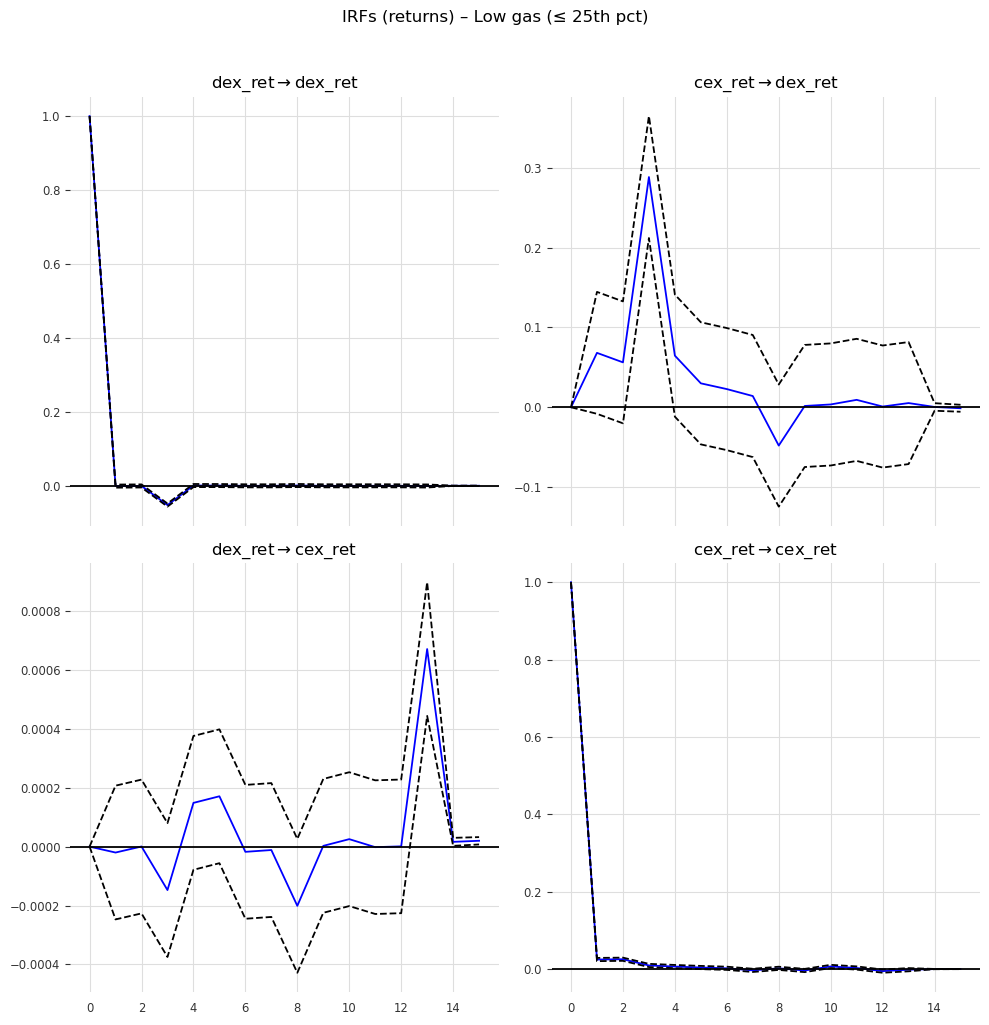

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Dec, 2025
Time:                     13:09:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -30.0300
Nobs:                     221867.    HQIC:                  -30.0318
Log likelihood:       2.70203e+06    FPE:                9.05839e-14
AIC:                     -30.0325    Det(Omega_mle):     9.05618e-14
--------------------------------------------------------------------
Results for equation dex_ret
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.000003         0.000005           -0.607           0.544
L1.dex_ret         -0.000887         0.002125           -0.417           0.677
L1.cex_ret          0.068193         0.038985            1.749    

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== VAR results: Med gas (25–75th pct) ===
Selected lag order (AIC): 15


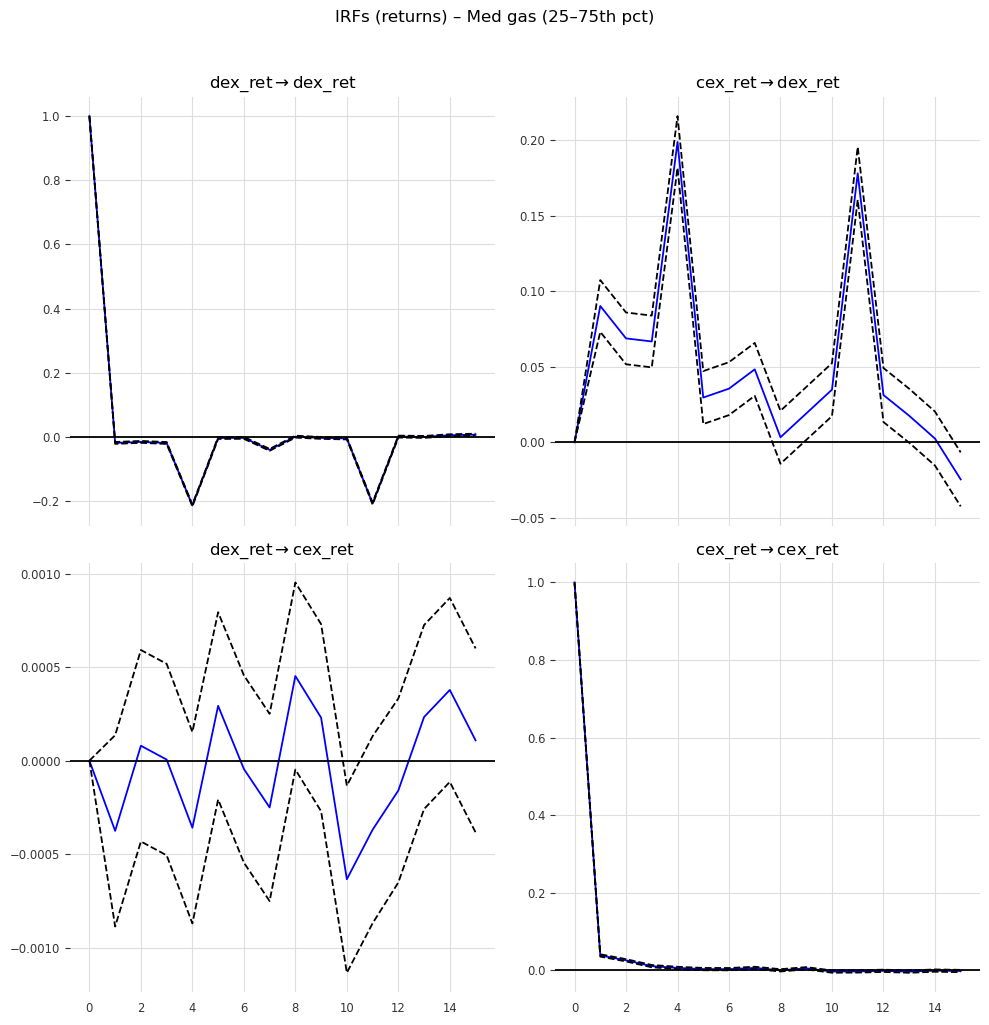

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Dec, 2025
Time:                     13:09:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -31.3607
Nobs:                     443738.    HQIC:                  -31.3618
Log likelihood:       5.69909e+06    FPE:                2.39647e-14
AIC:                     -31.3622    Det(Omega_mle):     2.39614e-14
--------------------------------------------------------------------
Results for equation dex_ret
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.000000         0.000001           -0.160           0.873
L1.dex_ret         -0.018047         0.001508          -11.969           0.000
L1.cex_ret          0.090268         0.008743           10.325    

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== VAR results: High gas (≥ 90th pct) ===
Selected lag order (AIC): 15


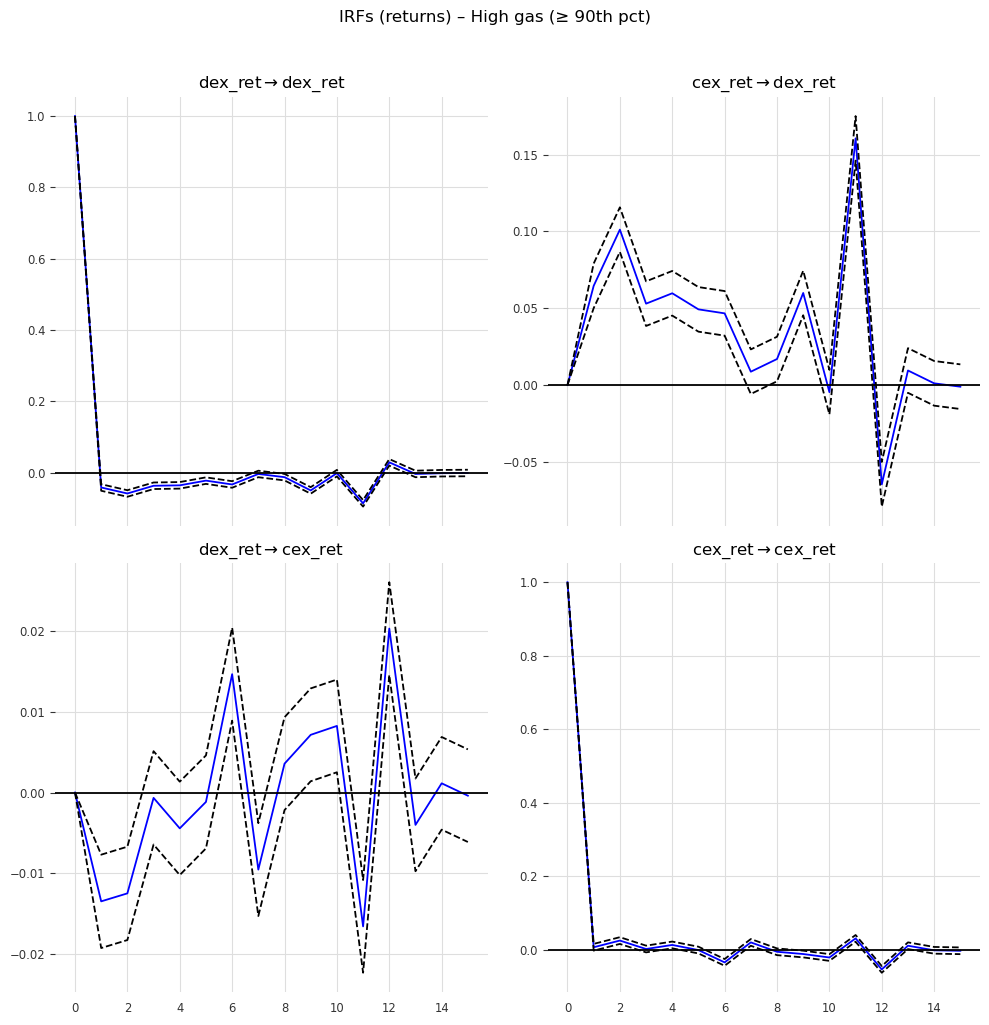

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Dec, 2025
Time:                     13:09:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -29.7761
Nobs:                     88737.0    HQIC:                  -29.7806
Log likelihood:       1.06965e+06    FPE:                1.16297e-13
AIC:                     -29.7826    Det(Omega_mle):     1.16216e-13
--------------------------------------------------------------------
Results for equation dex_ret
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.000000         0.000003            0.012           0.990
L1.dex_ret         -0.041105         0.004675           -8.793           0.000
L1.cex_ret          0.064570         0.007399            8.727    

In [123]:
from statsmodels.tsa.api import VAR

def fit_var_and_irf(df_reg, name, maxlags=15, irf_horizon=15):
    if df_reg['dex_ret'].std() == 0 or df_reg['cex_ret'].std() == 0:
        print(f"\n{name}: returns nearly constant, skipping VAR.")
        return

    data = df_reg[['dex_ret', 'cex_ret']].replace([np.inf, -np.inf], np.nan).dropna()

    if len(data) < maxlags + 10:
        print(f"\n{name}: not enough obs for VAR, skipping.")
        return

    model = VAR(data)
    results = model.fit(maxlags=maxlags, ic='aic')
    print(f"\n=== VAR results: {name} ===")
    print("Selected lag order (AIC):", results.k_ar)

    irf = results.irf(irf_horizon)
    fig = irf.plot(orth=False)
    fig.suptitle(f'IRFs (returns) – {name}', y=1.02)
    plt.tight_layout()
    plt.show()

    print(results.summary())

fit_var_and_irf(low_gas,  "Low gas (≤ 25th pct)")
fit_var_and_irf(med_gas,  "Med gas (25–75th pct)")
fit_var_and_irf(high_gas, "High gas (≥ 90th pct)")


Low gas VAR:

corr(dex_ret, cex_ret) = 0.04 => very weak

IRF plots - 
- cex_ret -> dex_ret (top right): positive humps => CEX shock feeds into DEX
- dex_ret -> cex_ret (bottom left): hugging zero

CEX shocks move DEX and DEX shocks do not move CEX. Supports CEX leading DEX.

Medium gas VAR:

corr(dex_ret, cex_ret) = 0.13 => stronger co-movement than low gas

IRF plots - 
- cex_ret -> dex_ret: same story as in the low gas environment
- dex_ret -> cex_ret: small still but slightly more fluctuations than in low gas

Still clearly CEX-led but DEX is a little more tightly coupled

High gas VAR:

corr(dex_ret, cex_ret) = 0.70 => massive co-movement

IRF plots - 
- cex_ret -> dex_ret: same story as in medium gas environment - DEX returns jump strongly after a CEX shock
- dex_ret -> cex_ret: now roughly 100x the magnitude than in the low and medium gas environments, shocks on DEX generate a noisy response on CEX

Both have strong co-movement and DEX shocks are now impacting CEX

Combined with the Granger results, this looks like a two-way price discovery during high gas periods. On-chain (DEX) activity is informative and off-chain (CEX) traders react to what's happening on-chain.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== FEVD: Low gas (≤ 25th pct) ===
Selected lag order (AIC): 13


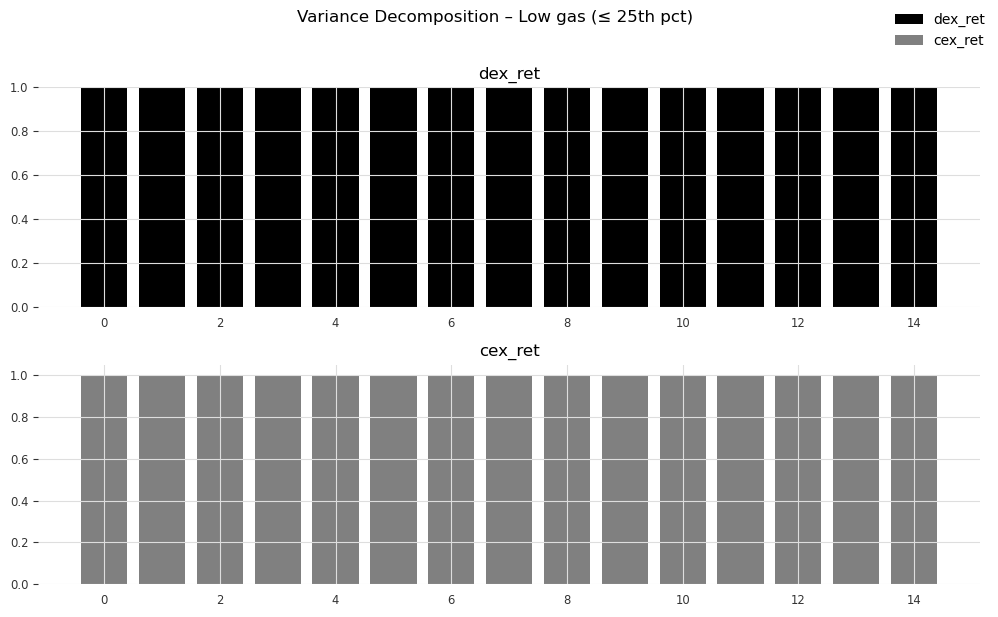

FEVD horizons available: 2
Using final horizon index 1 (≈ 6 seconds, since 3s bars).
  DEX_ret variance shares [shock from dex_ret, shock from cex_ret]: [0.00158116 0.99841884]
  CEX_ret variance shares [shock from dex_ret, shock from cex_ret]: [0.00158058 0.99841942]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== FEVD: Med gas (25–75th pct) ===
Selected lag order (AIC): 15


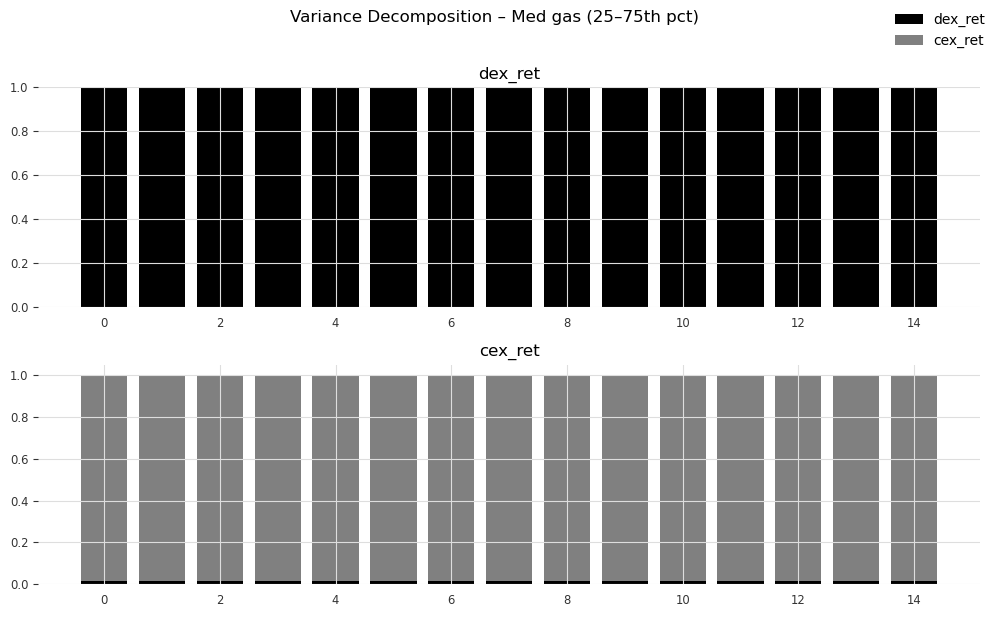

FEVD horizons available: 2
Using final horizon index 1 (≈ 6 seconds, since 3s bars).
  DEX_ret variance shares [shock from dex_ret, shock from cex_ret]: [0.01600912 0.98399088]
  CEX_ret variance shares [shock from dex_ret, shock from cex_ret]: [0.01599307 0.98400693]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== FEVD: High gas (≥ 90th pct) ===
Selected lag order (AIC): 15


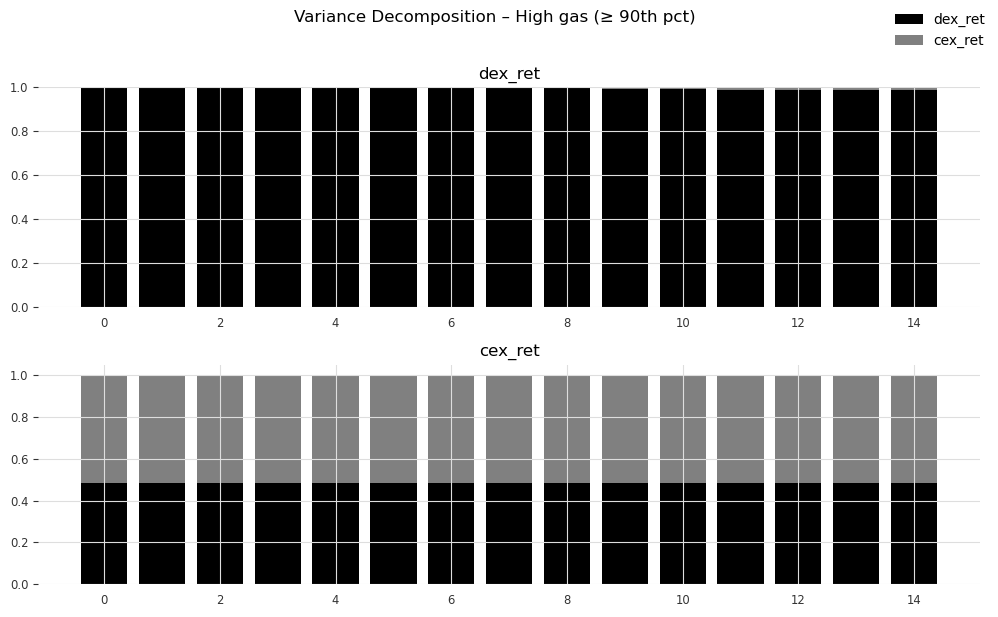

FEVD horizons available: 2
Using final horizon index 1 (≈ 6 seconds, since 3s bars).
  DEX_ret variance shares [shock from dex_ret, shock from cex_ret]: [0.4842635 0.5157365]
  CEX_ret variance shares [shock from dex_ret, shock from cex_ret]: [0.48438866 0.51561134]


In [126]:
from statsmodels.tsa.api import VAR
import numpy as np
import matplotlib.pyplot as plt

def var_fevd_only(df_reg, name, maxlags=15, fevd_horizon=15):
    # Basic sanity checks
    if df_reg['dex_ret'].std() == 0 or df_reg['cex_ret'].std() == 0:
        print(f"\n{name}: returns nearly constant, skipping VAR/FEVD.")
        return

    data = df_reg[['dex_ret', 'cex_ret']].replace([np.inf, -np.inf], np.nan).dropna()
    if len(data) < maxlags + 10:
        print(f"\n{name}: not enough obs for VAR/FEVD, skipping.")
        return

    model   = VAR(data)
    results = model.fit(maxlags=maxlags, ic='aic')

    print(f"\n=== FEVD: {name} ===")
    print("Selected lag order (AIC):", results.k_ar)

    # Ask for fevd_horizon, but then inspect what we actually got
    fevd = results.fevd(fevd_horizon)

    # Plot whatever FEVD was computed
    fig = fevd.plot(figsize=(10, 6))
    fig.suptitle(f'Variance Decomposition – {name}', y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Robust extraction of final-horizon shares ---
    decomp = fevd.decomp
    # Most statsmodels versions: shape = (steps, neqs, neqs)
    if decomp.ndim != 3:
        print("Unexpected FEVD decomp shape:", decomp.shape)
        return

    n_steps = decomp.shape[0]
    h_idx   = n_steps - 1  # last available step

    dex_shares = decomp[h_idx, 0, :]  # dex_ret variance split
    cex_shares = decomp[h_idx, 1, :]  # cex_ret variance split

    print(f"FEVD horizons available: {n_steps}")
    print(f"Using final horizon index {h_idx} "
          f"(≈ {3 * (h_idx + 1)} seconds, since 3s bars).")
    print("  DEX_ret variance shares [shock from dex_ret, shock from cex_ret]:",
          dex_shares)
    print("  CEX_ret variance shares [shock from dex_ret, shock from cex_ret]:",
          cex_shares)

# Run for each gas regime
var_fevd_only(low_gas,  "Low gas (≤ 25th pct)")
var_fevd_only(med_gas,  "Med gas (25–75th pct)")
var_fevd_only(high_gas, "High gas (≥ 90th pct)")


Low gas:

- DEX variance - Almost entirely explained by DEX's own shocks
- CEX variance - Almost entirely explained by CEX's own shocks

DEX and CEX have effectively independent volatility dynamics. Even though there was Granger causality, the FEVD shows the economic magnitude is small. CEX may predict DEX slightly in a regression sense but it does not meaningfully explain DEX's variability.

Medium gas:

Still overwhelmingly independent volatility dynamics but cross-influence is slightly higher than in low gas.

High gas:

- DEX variance explained: 48% by DEX's own shocks, 52% explained by CEX shocks
- CEX variance explained: 52% by CEX's own shocks, 48% explained by DEX chocks

CEX shocks become responsible for about half of DEX volatility and vice versa.

# THIS IS VERY IMPORTANT.


=== VECM: Low gas (≤ 25th pct) ===
Resampled to 5min, nobs = 3431
Johansen trace stats (r <= 0, r <= 1): [509.34716667   3.03311526]
95% critical values                 : [15.4943  3.8415]

Error-correction (alpha) coefficients:
  DEX adjustment speed: -0.9700
  CEX adjustment speed: -0.0142


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


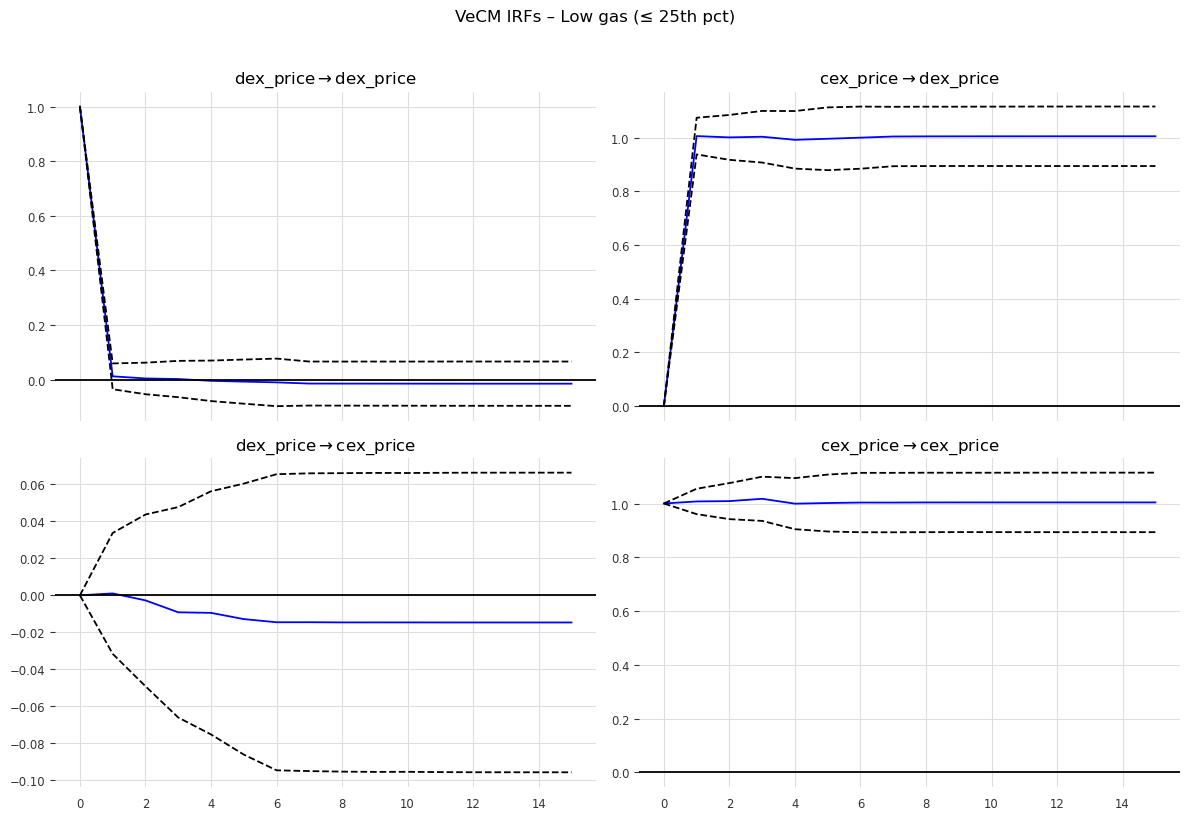

Det. terms outside the coint. relation & lagged endog. parameters for equation dex_price
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.dex_price    -0.0178      0.053     -0.337      0.736      -0.121       0.086
L1.cex_price     0.0348      0.059      0.595      0.552      -0.080       0.150
L2.dex_price    -0.0146      0.047     -0.307      0.759      -0.108       0.079
L2.cex_price     0.0100      0.054      0.186      0.853      -0.095       0.115
L3.dex_price    -0.0096      0.041     -0.233      0.816      -0.091       0.071
L3.cex_price     0.0081      0.048      0.168      0.867      -0.087       0.103
L4.dex_price    -0.0048      0.034     -0.142      0.887      -0.071       0.062
L4.cex_price    -0.0170      0.042     -0.404      0.686      -0.099       0.065
L5.dex_price    -0.0027      0.024     -0.111      0.912      -0.050       0.045
L5.cex_price     0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


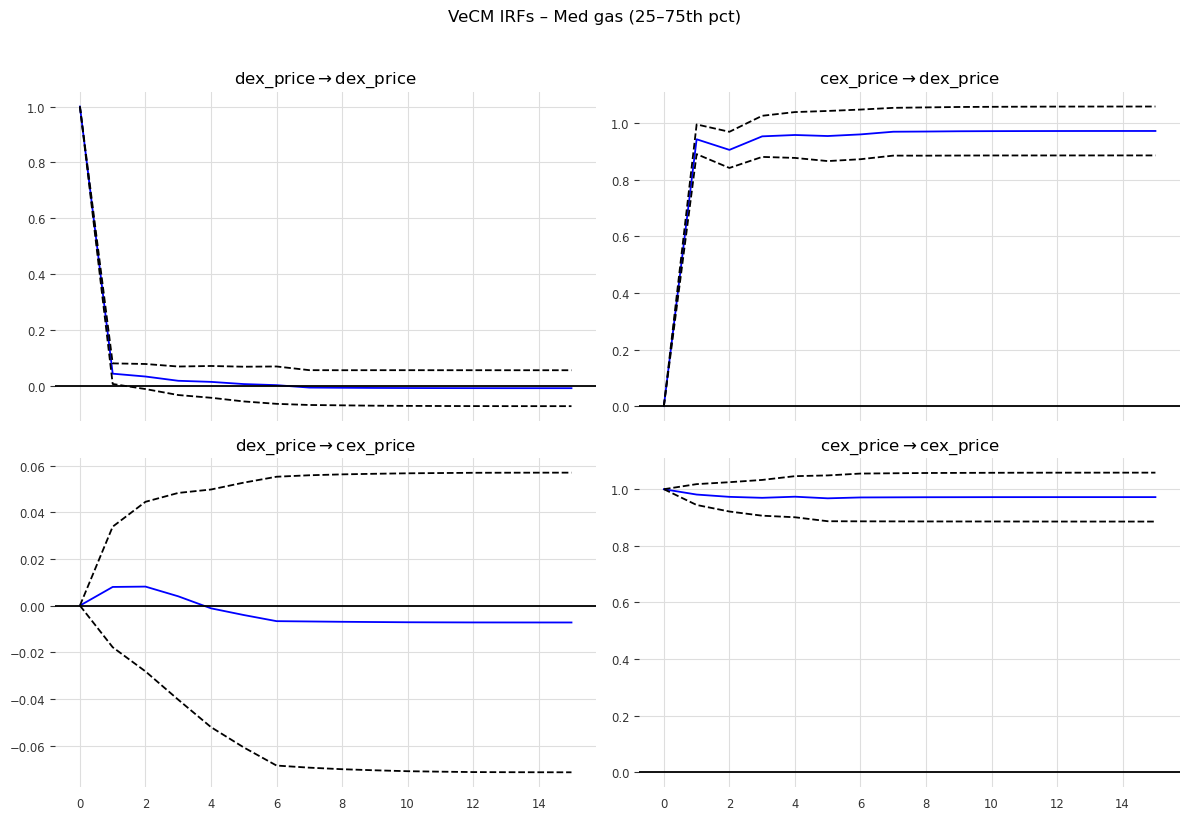

Det. terms outside the coint. relation & lagged endog. parameters for equation dex_price
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.dex_price    -0.0568      0.040     -1.428      0.153      -0.135       0.021
L1.cex_price     0.0442      0.044      1.001      0.317      -0.042       0.131
L2.dex_price    -0.0318      0.036     -0.884      0.376      -0.102       0.039
L2.cex_price    -0.0176      0.041     -0.432      0.666      -0.097       0.062
L3.dex_price    -0.0223      0.031     -0.710      0.478      -0.084       0.039
L3.cex_price     0.0148      0.037      0.403      0.687      -0.057       0.087
L4.dex_price    -0.0126      0.026     -0.483      0.629      -0.064       0.039
L4.cex_price     0.0128      0.032      0.397      0.691      -0.050       0.076
L5.dex_price    -0.0059      0.019     -0.313      0.754      -0.043       0.031
L5.cex_price    -0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


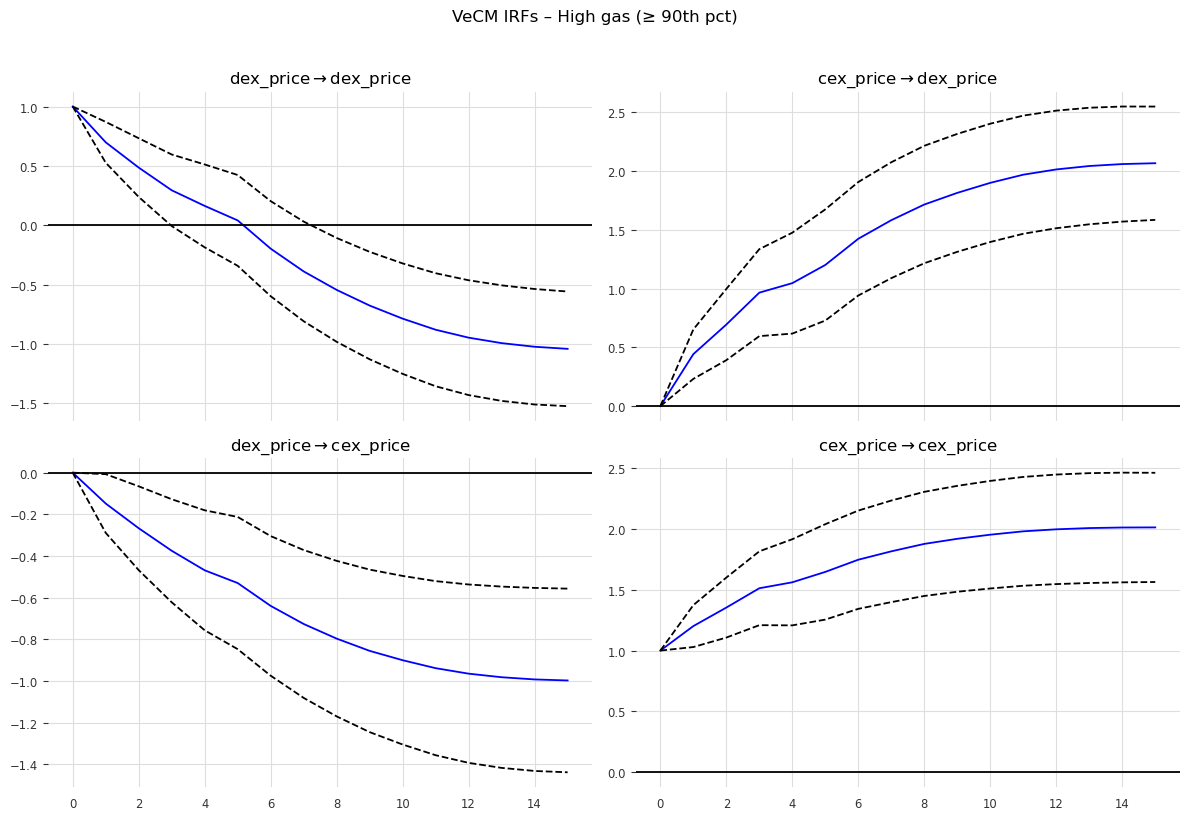

Det. terms outside the coint. relation & lagged endog. parameters for equation dex_price
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
L1.dex_price    -0.0015      0.088     -0.017      0.986      -0.174       0.171
L1.cex_price     0.1407      0.108      1.302      0.193      -0.071       0.352
L2.dex_price     0.0617      0.088      0.702      0.483      -0.111       0.234
L2.cex_price    -0.0054      0.108     -0.050      0.960      -0.218       0.207
L3.dex_price     0.0691      0.088      0.789      0.430      -0.103       0.241
L3.cex_price     0.0241      0.108      0.224      0.823      -0.187       0.235
L4.dex_price     0.1216      0.087      1.390      0.164      -0.050       0.293
L4.cex_price    -0.1576      0.108     -1.466      0.143      -0.368       0.053
L5.dex_price     0.1230      0.086      1.422      0.155      -0.046       0.292
L5.cex_price    -0.0

In [129]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# 0. Rebuild regimes on the *level* data (df_with_gas)
# ------------------------------------------------------------------
df_levels = df_with_gas[['dex_price', 'cex_price', 'base_fee_gwei']].copy()

q = df_levels['base_fee_gwei'].quantile([0.25, 0.75, 0.9])

low_lvl  = df_levels[df_levels['base_fee_gwei'] <= q[0.25]]
med_lvl  = df_levels[(df_levels['base_fee_gwei'] > q[0.25]) &
                     (df_levels['base_fee_gwei'] <= q[0.75])]
high_lvl = df_levels[df_levels['base_fee_gwei'] >= q[0.9]]

regime_levels = {
    "Low gas (≤ 25th pct)"  : low_lvl,
    "Med gas (25–75th pct)" : med_lvl,
    "High gas (≥ 90th pct)" : high_lvl,
}

# ------------------------------------------------------------------
# 1. Helper to prep levels (downsample to 5-min, drop NaNs)
# ------------------------------------------------------------------
def prepare_levels(df_reg, freq='5min'):
    lev = df_reg[['dex_price', 'cex_price']].copy()
    lev = lev.sort_index()
    lev = lev.resample(freq).last().dropna()
    return lev

# ------------------------------------------------------------------
# 2. Run VECM + Johansen + IRF for a single regime
# ------------------------------------------------------------------
def run_vecm_regime(df_reg, name, freq='5min', k_ar_diff=5, irf_horizon=15):
    levels = prepare_levels(df_reg, freq=freq)

    if len(levels) < (k_ar_diff + 30):
        print(f"\n{name}: not enough observations after resample ({len(levels)} rows). Skipping.")
        return

    print(f"\n=== VECM: {name} ===")
    print(f"Resampled to {freq}, nobs = {len(levels)}")

    # Johansen cointegration test on this regime
    jres = coint_johansen(levels[['dex_price', 'cex_price']], det_order=0, k_ar_diff=k_ar_diff)
    trace_stats = jres.lr1
    crit_95 = jres.cvt[:, 1]

    print("Johansen trace stats (r <= 0, r <= 1):", trace_stats)
    print("95% critical values                 :", crit_95)

    # We expect 1 cointegration relationship like in the full sample
    coint_rank = 1

    vecm_model = VECM(levels, k_ar_diff=k_ar_diff,
                      coint_rank=coint_rank, deterministic="ci")
    vecm_res = vecm_model.fit()

    # Error-correction speeds (alpha)
    alpha = vecm_res.alpha
    print("\nError-correction (alpha) coefficients:")
    print(f"  DEX adjustment speed: {alpha[0, 0]:.4f}")
    print(f"  CEX adjustment speed: {alpha[1, 0]:.4f}")

    # IRFs for this regime (levels)
    irf = vecm_res.irf(irf_horizon)
    fig = irf.plot(orth=False, figsize=(12, 8))
    fig.suptitle(f'VeCM IRFs – {name}', y=1.02)
    plt.tight_layout()
    plt.show()

    print(vecm_res.summary())

# ------------------------------------------------------------------
# 3. Run for all three regimes
# ------------------------------------------------------------------
for name, df_reg in regime_levels.items():
    run_vecm_regime(df_reg, name,
                    freq='5min',   # or '1min' if memory is OK and you want finer detail
                    k_ar_diff=5)   # you can bump to 10 if AIC prefers and RAM allows


Low gas:

Johansen trace: 

509.3 > critical value 15.49

3.03 < critical value 3.84

=> There is exactly 1 cointegrating relationship

- DEX alpha = -0.970 (highly significant)
- CEX alpha = -0.014 (not significant)

=> DEX aggressively corrects deviations from equilibrium while CEX does not respond, so when the two diverge, DEX adjusts while CEX ignores the divergence. This points to CEX being the price leader and DEX lagging.

IRF plots:

- cex_price -> dex_price (top right): CEX shock causes a large and sustained response in DEX => DEX follows CEX
- dex_price -> cex_price (bottom left): DEX shock produces very slight downward shock in CEX but not significant => CEX ignores DEX

Medium gas:

Johansen trace:

791.1 > critical vaue 15.49

1.96 < critical value 3.84

=> There is exactly 1 cointegrating relationship

- DEX alpha = -0.8985 (highly significant)
- CEX alpha = -0.0067 (not significant)

=> Same as low gas

IRF plots:

- cex_price -> dex_price (top right): Same as low gas but jump is slightly lower in magnitude than low gas.
- dex_price -> cex_price (bottom left): Same as low gas

High gas:

Johansen trace:

88.2 > critical value 15.49

0.92 < critical value 3.84

=> There is exactly 1 cointegrating relationship

- DEX alpha = -0.2998 (significant)
- CEX alpha = -0.1452 (significant)

=> Both adjust to divergence, CEX is no longer the dominant leader, both partake in price discovery

IRF plots:

- cex_price -> dex_price (top right): CEX shock causes an overall larger response in DEX, it looks almost like an increasing exponential decay function, the initial shock is less dramatic than in the low and medium gas cases but not by much, after which sustains and even increases
- dex_price -> cex_price (bottom left): DEX shock produces a significant downward shock to CEX
- dex_price -> dex_price (top left): the self-response to shock is slowly decaying and sustained, price movements are sustained longer
- cex_price -> cex_price (bottom right): CEX self-response is smooth but significant

Overall, in during high gas, the structural divergence in price reverses gradually instead of instantly. 


## Does cointegration ever breakdown because of gas?

In [130]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use PRICES (not returns)
df_test = df_with_gas[['dex_price', 'cex_price', 'base_fee_gwei']].dropna()

# Rolling parameters
window = 3000          # ~ 2.5 hours if 3s data
step   = 300           # evaluate every 15 minutes
alpha  = 0.05

trace_stats = []
crit_vals   = []
gas_levels  = []
dates       = []

for i in range(window, len(df_test), step):
    sub = df_test.iloc[i-window:i]

    # Johansen test
    joh = coint_johansen(sub[['dex_price', 'cex_price']], det_order=0, k_ar_diff=1)

    # Trace stat for r = 0 (test existence of cointegration)
    trace = joh.lr1[0]
    crit  = joh.cvt[0, 1]   # 5% critical value

    trace_stats.append(trace)
    crit_vals.append(crit)
    gas_levels.append(sub['base_fee_gwei'].median())
    dates.append(sub.index[-1])

rolling = pd.DataFrame({
    "trace": trace_stats,
    "critical": crit_vals,
    "gas": gas_levels
}, index=pd.to_datetime(dates))


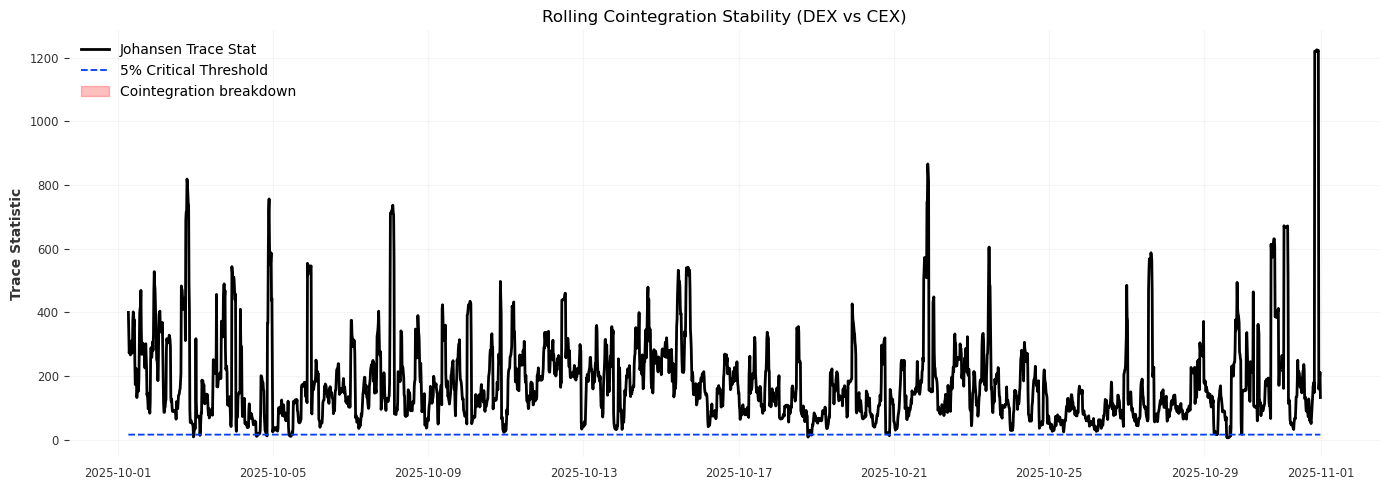

In [131]:
plt.figure(figsize=(14,5))

plt.plot(rolling.index, rolling['trace'], label="Johansen Trace Stat", lw=2)
plt.plot(rolling.index, rolling['critical'], linestyle="--", label="5% Critical Threshold")

plt.fill_between(
    rolling.index,
    rolling['trace'],
    rolling['critical'],
    where=(rolling['trace'] < rolling['critical']),
    color='red',
    alpha=0.25,
    label="Cointegration breakdown"
)

plt.title("Rolling Cointegration Stability (DEX vs CEX)")
plt.ylabel("Trace Statistic")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


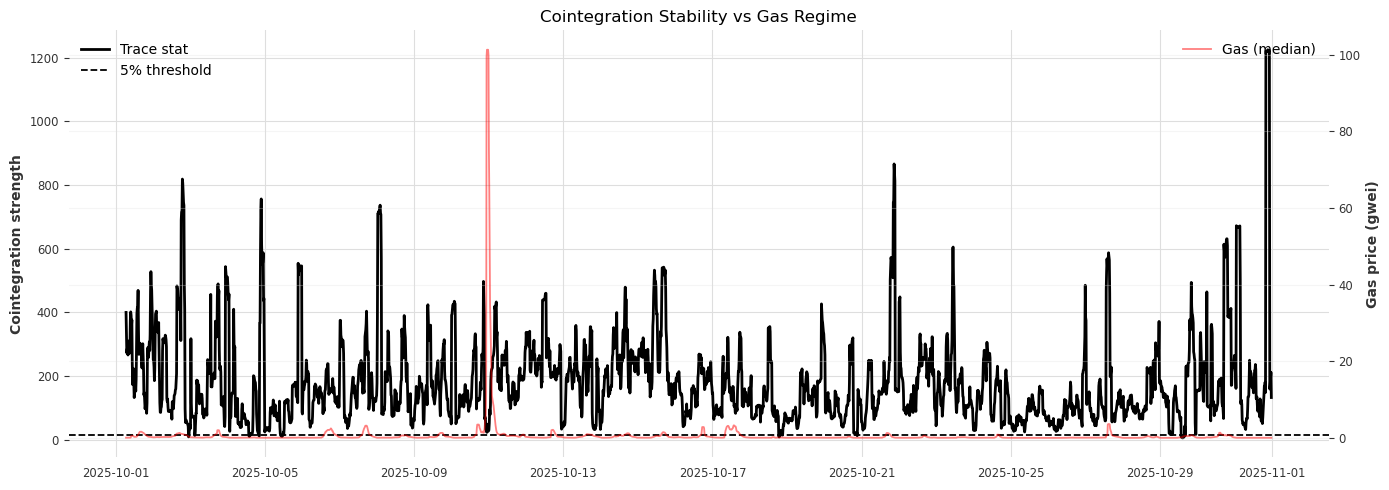

In [132]:
fig, ax1 = plt.subplots(figsize=(14,5))

# Cointegration strength
ax1.plot(rolling.index, rolling['trace'], label="Trace stat", lw=2)
ax1.axhline(rolling['critical'].iloc[0], linestyle='--', color='black', label="5% threshold")
ax1.set_ylabel("Cointegration strength")
ax1.legend(loc="upper left")

# Gas (secondary axis)
ax2 = ax1.twinx()
ax2.plot(rolling.index, rolling['gas'], color='red', alpha=0.5, label="Gas (median)")
ax2.set_ylabel("Gas price (gwei)")

plt.title("Cointegration Stability vs Gas Regime")
ax2.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


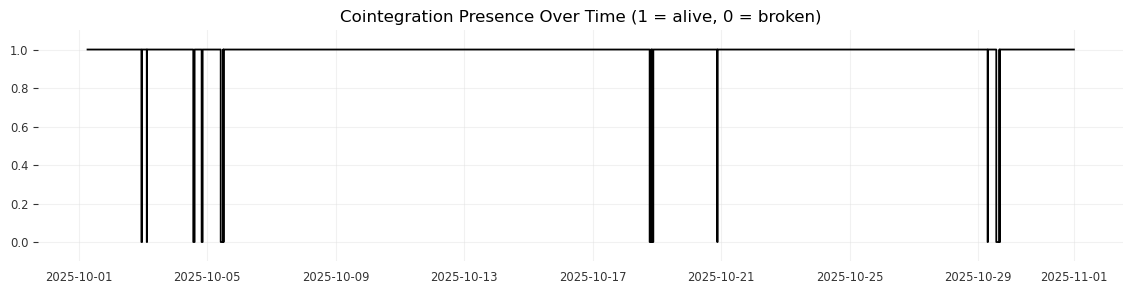

In [133]:
rolling['cointegrated'] = (rolling['trace'] > rolling['critical']).astype(int)

plt.figure(figsize=(14,3))
plt.plot(rolling.index, rolling['cointegrated'], drawstyle='steps-post')
plt.title("Cointegration Presence Over Time (1 = alive, 0 = broken)")
plt.ylim(-0.1, 1.1)
plt.grid(alpha=0.4)
plt.show()


## No, cointegration seems to not have any relationship with gas.

## Let's backtest a strategy where we condition on being in a high gas regime and then during that high gas regime we trade based on whether DEX or CEX is leading or lagging the other.

In [214]:
import numpy as np
import pandas as pd

df = df_with_gas.copy()

# Returns
df['dex_ret'] = df['dex_price'].pct_change()
df['cex_ret'] = df['cex_price'].pct_change()

df = df.dropna()


In [215]:
hi_q = df['base_fee_gwei'].quantile(0.90)

df['high_gas'] = df['base_fee_gwei'] >= hi_q

In [216]:
# Estimate hedge ratio
X = np.c_[np.ones(len(df)), df['cex_price']]
beta = np.linalg.lstsq(X, df['dex_price'], rcond=None)[0][1]

# Spread
df['spread'] = df['dex_price'] - beta * df['cex_price']

# Rolling z score
window = 2000
df['spread_z'] = (df['spread'] - df['spread'].rolling(window).mean()) / df['spread'].rolling(window).std()


In [217]:
N = 15   # 30 seconds lookback (10 * 3s)

df['cex_leads'] = df['cex_ret'].rolling(N).corr(df['dex_ret'].shift(1))
df['dex_leads'] = df['dex_ret'].rolling(N).corr(df['cex_ret'].shift(1))

df['leader'] = np.where(df['cex_leads'] > df['dex_leads'], 'CEX', 'DEX')


CEX leads -> trade DEX

DEX leads -> trade CEX

Is there significant number of market participants actually trading the lead-lag relationship in low gas regime? if so then as soon as the gas regime becomes high we take advantage of the change in lead lag relationship?

In [218]:
df['position_dex'] = 0
df['position_cex'] = 0

shock = 0.008   # entry threshold on returns
exit_z = 0.5    # exit when spread reverts

for i in range(N+1, len(df)):
    row = df.iloc[i]

    if not row['high_gas']:
        continue

    # ENTRY
    # If DEX shocks and DEX is leader → trade on CEX leg
    if abs(row['dex_ret']) > shock and row['leader'] == 'DEX' and df.iloc[i-1]['position_cex'] == 0:
        df.iloc[i, df.columns.get_loc('position_cex')] = np.sign(row['dex_ret'])

    # If CEX shocks and CEX is leader → trade on DEX leg
    if abs(row['cex_ret']) > shock and row['leader'] == 'CEX' and df.iloc[i-1]['position_dex'] == 0:
        df.iloc[i, df.columns.get_loc('position_dex')] = np.sign(row['cex_ret'])

    # HOLD (carry previous positions)
    df.iloc[i, df.columns.get_loc('position_cex')] += df.iloc[i-1]['position_cex']
    df.iloc[i, df.columns.get_loc('position_dex')] += df.iloc[i-1]['position_dex']

    # EXIT on convergence of the spread
    if abs(row['spread_z']) < exit_z:
        df.iloc[i, df.columns.get_loc('position_cex')] = 0
        df.iloc[i, df.columns.get_loc('position_dex')] = 0

# --- Gross PnL (before costs) ---
df['pnl_cex'] = df['position_cex'].shift(1) * df['cex_ret']
df['pnl_dex'] = df['position_dex'].shift(1) * df['dex_ret']
df['pnl'] = df[['pnl_cex', 'pnl_dex']].sum(axis=1)
df['equity'] = df['pnl'].cumsum()          # gross equity (keep if you want)

# =======================================================================
#                     TRANSACTION COSTS LAYER
# =======================================================================

# 1) Trade sizes (changes in position)
df['trade_dex'] = df['position_dex'].fillna(0) - df['position_dex'].shift(1).fillna(0)
df['trade_cex'] = df['position_cex'].fillna(0) - df['position_cex'].shift(1).fillna(0)

# Absolute volume in "units" of your strategy (if positions are -1/0/1, this is 0 or 1)
df['vol_dex'] = df['trade_dex'].abs()
df['vol_cex'] = df['trade_cex'].abs()

# 2) Parameters (tune these!)
cex_fee  = 0.0005   # 5 bps on CEX
dex_fee  = 0.0003   # 3 bps on DEX
slip_cex = 0.0001   # 1 bp slippage CEX
slip_dex = 0.0005   # 5 bps slippage DEX

gas_per_swap      = 120_000   # gas units per DEX swap (ballpark)
priority_tip_gwei = 2.0       # extra tip over base_fee
gwei_to_eth       = 1e-9

# 3) Gas cost per DEX trade, as a fraction of 1 ETH notional
df['eth_mid'] = 0.5 * (df['dex_price'] + df['cex_price'])

df['gas_price_gwei'] = df['base_fee_gwei'] + priority_tip_gwei
df['gas_cost_eth'] = df['gas_price_gwei'] * gwei_to_eth * gas_per_swap

# Return hit per 1 ETH traded on DEX
df['gas_cost_ret_per_trade'] = df['gas_cost_eth'] / df['eth_mid']

# Only pay gas when you actually trade on DEX
df['gas_cost_ret'] = df['gas_cost_ret_per_trade'] * df['vol_dex']

# 4) Fee + slippage cost (return space)
df['cex_cost_ret'] = (cex_fee + slip_cex) * df['vol_cex']
df['dex_cost_ret'] = (dex_fee + slip_dex) * df['vol_dex']

# 5) Total transaction costs (in return units)
df['tx_cost_ret'] = df['cex_cost_ret'] + df['dex_cost_ret'] + df['gas_cost_ret']

# 6) Net PnL and equity
df['pnl_gross'] = df['pnl']
df['pnl_net']   = df['pnl_gross'] - df['tx_cost_ret']

df['equity_gross'] = df['pnl_gross'].cumsum()
df['equity_net']   = df['pnl_net'].cumsum()

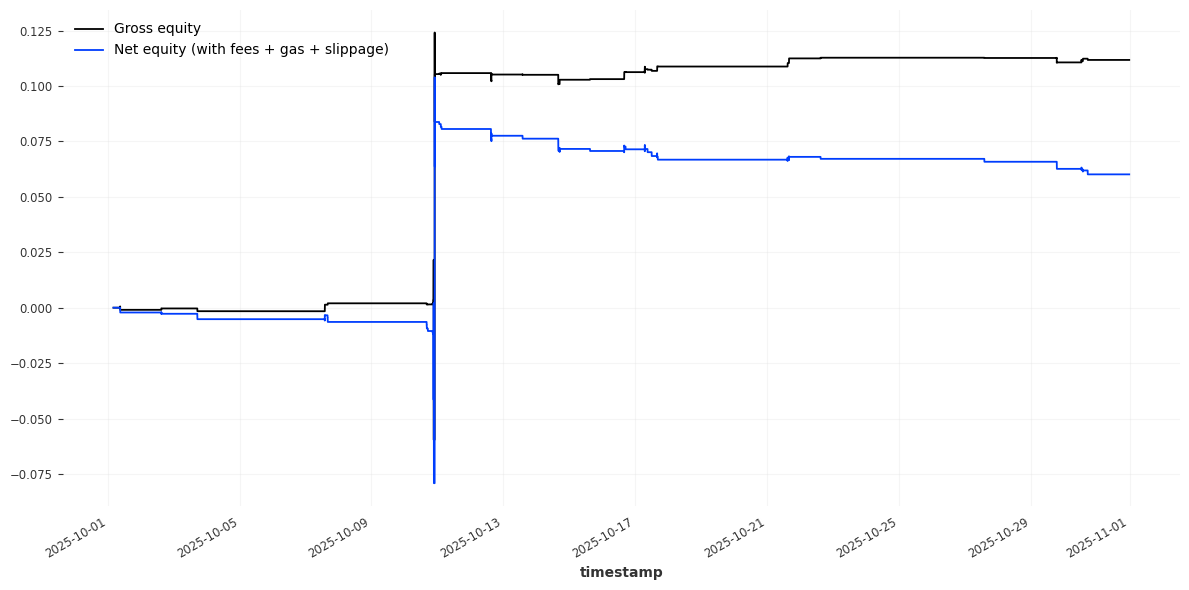

In [219]:
plt.figure(figsize=(12,6))
df['equity_gross'].plot(label='Gross equity')
df['equity_net'].plot(label='Net equity (with fees + gas + slippage)')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

In [220]:
print("Sharpe:", df['pnl_net'].mean() / df['pnl_net'].std() * np.sqrt(1200))
print("Trades:", (df['position_dex'].diff()!=0).sum() + (df['position_cex'].diff()!=0).sum())
print("Win rate:", (df['pnl_net'] > 0).mean())


Sharpe: 0.011310292299666222
Trades: 86
Win rate: 9.69003166161508e-05


In [234]:
# Identify the biggest PnL spike
df['delta_equity'] = df['equity_net'].diff()

big_trade_idx = df['delta_equity'].abs().idxmax()
print("Largest equity move at:", big_trade_idx)
print("PnL jump:", df.loc[big_trade_idx, 'delta_equity'])

# Define zoom window (±15 minutes)
window_bars = int(60 * 60 / 3)   # 15 minutes worth of 3-second bars
center = df.index.get_loc(big_trade_idx)
start  = max(0, center - window_bars)
end    = min(len(df), center + window_bars)

zoom = df.iloc[start:end].copy()


Largest equity move at: 2025-10-10 22:00:21+00:00
PnL jump: 0.17615124379555963


In [235]:
print("Bars before trade:", center)
print("Requested window size:", window_bars)
print("Zoom start:", df.index[start])
print("Zoom end:", df.index[end-1])

Bars before trade: 280604
Requested window size: 1200
Zoom start: 2025-10-10 21:00:21+00:00
Zoom end: 2025-10-10 23:00:18+00:00


In [236]:
zoom[['pnl_net','equity_net','position_dex','position_cex']].describe()


,pnl_net,equity_net,position_dex,position_cex
count,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.000040,0.012443,0.400417,0.056250
std,0.003986,0.074690,0.535602,0.283936
min,-0.073558,-0.079145,-1.000000,-1.000000
25%,0.000000,-0.079145,0.000000,0.000000
50%,0.000000,0.032812,0.000000,0.000000
75%,0.000000,0.083746,1.000000,0.000000
max,0.176151,0.103893,1.000000,1.000000


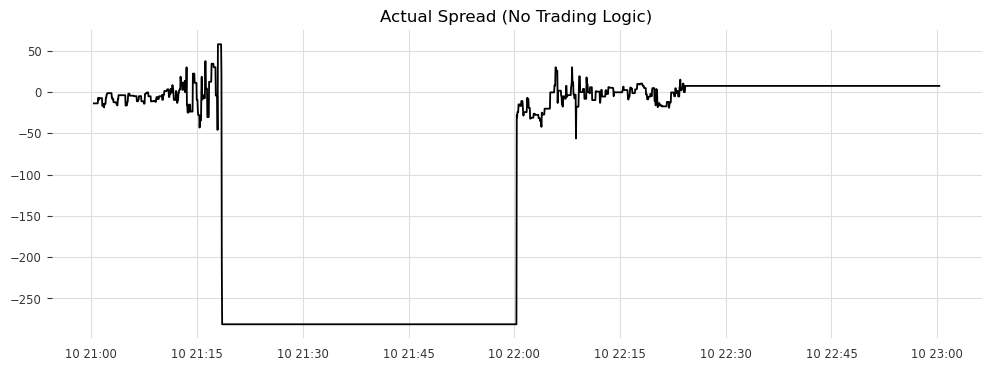

In [237]:
plt.figure(figsize=(12,4))
plt.plot(zoom.index, zoom['spread'])
plt.title("Actual Spread (No Trading Logic)")
plt.show()


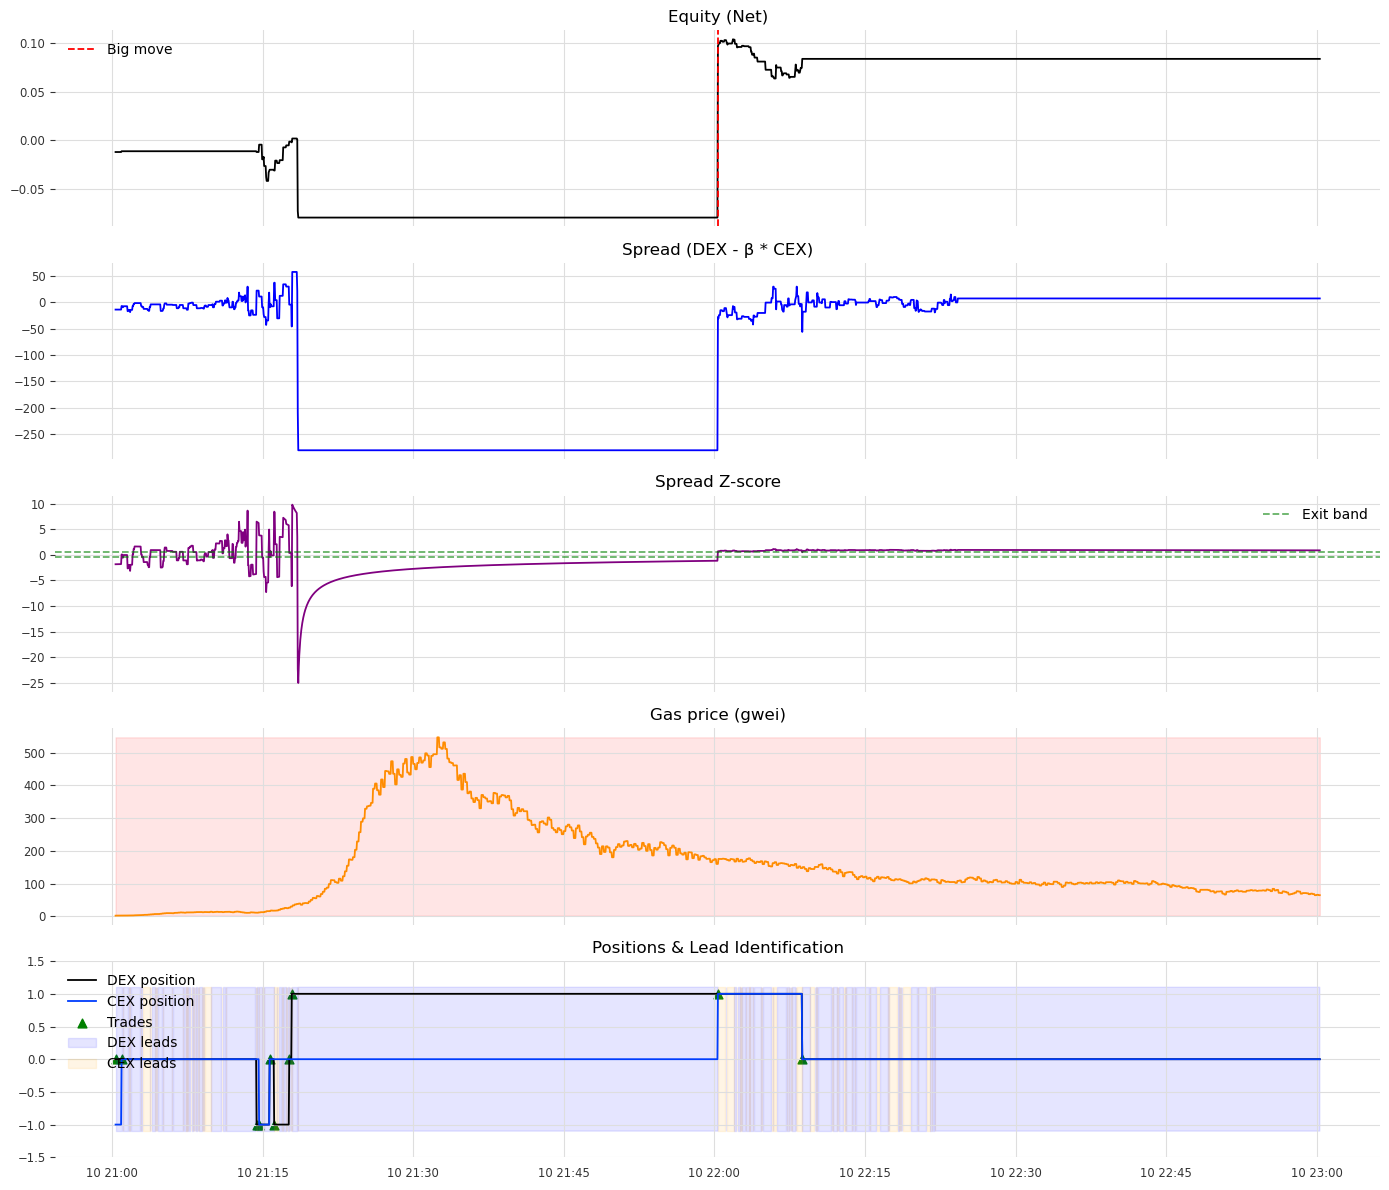

In [238]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

# ===========================
# 1) Equity zoom
# ===========================
axes[0].plot(zoom.index, zoom['equity_net'], color='black')
axes[0].axvline(big_trade_idx, color='red', linestyle='--', label="Big move")
axes[0].set_title("Equity (Net)")
axes[0].legend()


# ===========================
# 2) Spread
# ===========================
axes[1].plot(zoom.index, zoom['spread'], color='blue')
axes[1].set_title("Spread (DEX - β * CEX)")


# ===========================
# 3) Z-score
# ===========================
axes[2].plot(zoom.index, zoom['spread_z'], color='purple')
axes[2].axhline(0.5, color='green', linestyle='--', alpha=0.6, label='Exit band')
axes[2].axhline(-0.5, color='green', linestyle='--', alpha=0.6)
axes[2].set_title("Spread Z-score")
axes[2].legend()


# ===========================
# 4) Gas regime
# ===========================
axes[3].plot(zoom.index, zoom['base_fee_gwei'], color='darkorange')
axes[3].set_title("Gas price (gwei)")

# Shade high-gas regime
axes[3].fill_between(zoom.index, 
                     zoom['base_fee_gwei'].min(), 
                     zoom['base_fee_gwei'].max(),
                     where=zoom['high_gas'], 
                     color='red', alpha=0.1,label='High Gas')


# ===========================
# 5) Position + Leader
# ===========================
axes[4].plot(zoom.index, zoom['position_dex'], label="DEX position")
axes[4].plot(zoom.index, zoom['position_cex'], label="CEX position")

# Mark entries/exits
entry_idx = zoom.index[(zoom['position_dex'].diff() != 0) | (zoom['position_cex'].diff() != 0)]
axes[4].scatter(entry_idx, 
                zoom.loc[entry_idx, 'position_dex'], 
                marker='^', color='green', s=40, label='Trades')

# Leader coloring
dex_leads = zoom['leader'] == 'DEX'
cex_leads = zoom['leader'] == 'CEX'

axes[4].fill_between(zoom.index, -1.1, 1.1, where=dex_leads, alpha=0.1, color='blue', label='DEX leads')
axes[4].fill_between(zoom.index, -1.1, 1.1, where=cex_leads, alpha=0.1, color='orange', label='CEX leads')

axes[4].set_ylim([-1.5, 1.5])
axes[4].set_title("Positions & Lead Identification")
axes[4].legend(loc="upper left")

plt.tight_layout()
plt.show()


## Now let's backtest the strategy where we condition on low/medium gas regimes and we trade the lead/lag relationship we found in research

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# LOAD & SORT
# ==========================================
df = df_with_gas.copy().sort_index()

# ==========================================
# 1) RETURNS
# ==========================================
df['dex_ret'] = df['dex_price'].pct_change()
df['cex_ret'] = df['cex_price'].pct_change()

# ==========================================
# 2) GAS REGIMES (LOW + MED)
# ==========================================
q25 = df['base_fee_gwei'].quantile(0.25)
q75 = df['base_fee_gwei'].quantile(0.75)
df['low_med_gas'] = df['base_fee_gwei'] <= q75

print("Gas regime cutoffs:")
print("25th pct:", q25)
print("75th pct:", q75)

# ==========================================
# 3) HEDGE RATIO (DEX ~ beta * CEX)
# ==========================================
X = np.c_[np.ones(len(df)), df['cex_price'].values]
y = df['dex_price'].values
beta = np.linalg.lstsq(X, y, rcond=None)[0][1]
print("Hedge ratio beta:", beta)

df['spread'] = df['dex_price'] - beta * df['cex_price']

# ==========================================
# 4) GAS COST CONSTRUCTION (DO THIS FIRST)
# ==========================================
gas_used = 120_000
priority_tip = 2.0
gwei = 1e-9

df['eth_mid'] = 0.5 * (df['dex_price'] + df['cex_price'])
df['gas_eth'] = (df['base_fee_gwei'] + priority_tip) * gwei * gas_used
df['gas_cost_ret'] = df['gas_eth'] / df['eth_mid']

# ==========================================
# 5) Z-SCORE (EXIT SIGNAL)
# ==========================================
window = 1000
df['spread_z'] = (df['spread'] - df['spread'].rolling(window).mean()) / df['spread'].rolling(window).std()

# ==========================================
# 6) CLEAN DATA (CRITICAL)
# ==========================================
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['dex_ret', 'cex_ret', 'spread_z', 'gas_cost_ret'])

# ==========================================
# 7) STRATEGY PARAMETERS
# ==========================================
shock = 0.008
exit_z = 0.5

cex_fee  = 0.0005
dex_fee  = 0.0003
slip_cex = 0.0001
slip_dex = 0.0005

# ==========================================
# 8) POSITIONS + LOOP
# ==========================================
df['pos_dex'] = np.zeros(len(df))
df['pnl']     = np.zeros(len(df))

pos_idx = df.columns.get_loc('pos_dex')
pnl_idx = df.columns.get_loc('pnl')
dexr_idx = df.columns.get_loc('dex_ret')
cexr_idx = df.columns.get_loc('cex_ret')
z_idx = df.columns.get_loc('spread_z')
gas_idx = df.columns.get_loc('gas_cost_ret')
flag_idx = df.columns.get_loc('low_med_gas')

for i in range(1, len(df)):

    # =============================
    # MARK TO MARKET
    # =============================
    df.iat[i, pnl_idx] += df.iat[i-1, pos_idx] * df.iat[i, dexr_idx]

    # Carry position
    df.iat[i, pos_idx] = df.iat[i-1, pos_idx]

    # Only trade in LOW + MED GAS
    if not df.iat[i, flag_idx]:
        continue

    # =============================
    # ENTRY: CEX leads → trade DEX
    # =============================
    if abs(df.iat[i, cexr_idx]) > shock and df.iat[i, pos_idx] == 0:

        side = np.sign(df.iat[i, cexr_idx])
        df.iat[i, pos_idx] = side

        # Pay DEX cost
        df.iat[i, pnl_idx] -= (dex_fee + slip_dex + df.iat[i, gas_idx])

    # =============================
    # EXIT: Spread converges
    # =============================
    if abs(df.iat[i, z_idx]) < exit_z and df.iat[i, pos_idx] != 0:

        df.iat[i, pnl_idx] -= (dex_fee + slip_dex + df.iat[i, gas_idx])
        df.iat[i, pos_idx] = 0

# ==========================================
# 9) EQUITY
# ==========================================
df['equity'] = df['pnl'].cumsum()


Gas regime cutoffs:
25th pct: 0.11184182425
75th pct: 0.389228204
Hedge ratio beta: 1.0021526542917791


In [251]:
# 10) PERFORMANCE METRICS
# =====================================================
ret = df['pnl'].replace([np.inf, -np.inf], np.nan).dropna().values

mu = np.mean(ret)
sig = np.std(ret)

bars_per_year = (365*24*60*60) / 3
sharpe = (np.sqrt(bars_per_year) * mu / sig) if sig > 0 else 0

print("\n=== STRATEGY 1 RESULTS (Low + Med Gas Only) ===")
print("Sharpe:", sharpe)
print("Total PnL:", df['equity'].iloc[-1])


=== STRATEGY 1 RESULTS (Low + Med Gas Only) ===
Sharpe: -12.522487451619314
Total PnL: -0.034133563061858045


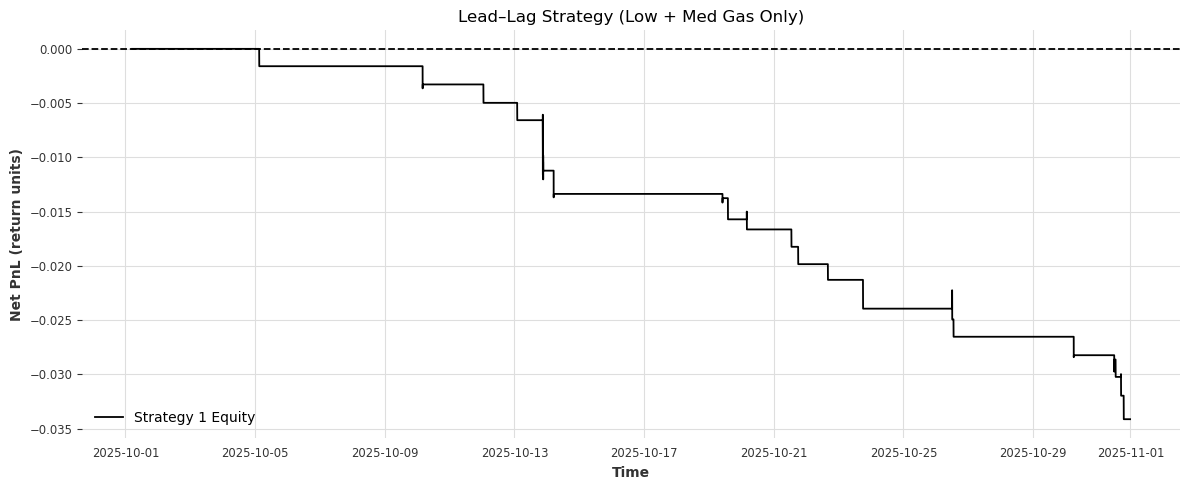

In [252]:
# =====================================================
# 11) PLOT
# =====================================================
plt.figure(figsize=(12,5))
plt.plot(df.index, df['equity'], label="Strategy 1 Equity")
plt.axhline(0, color='black', linestyle='--')
plt.title("Lead–Lag Strategy (Low + Med Gas Only)")
plt.xlabel("Time")
plt.ylabel("Net PnL (return units)")
plt.legend()
plt.tight_layout()
plt.show()

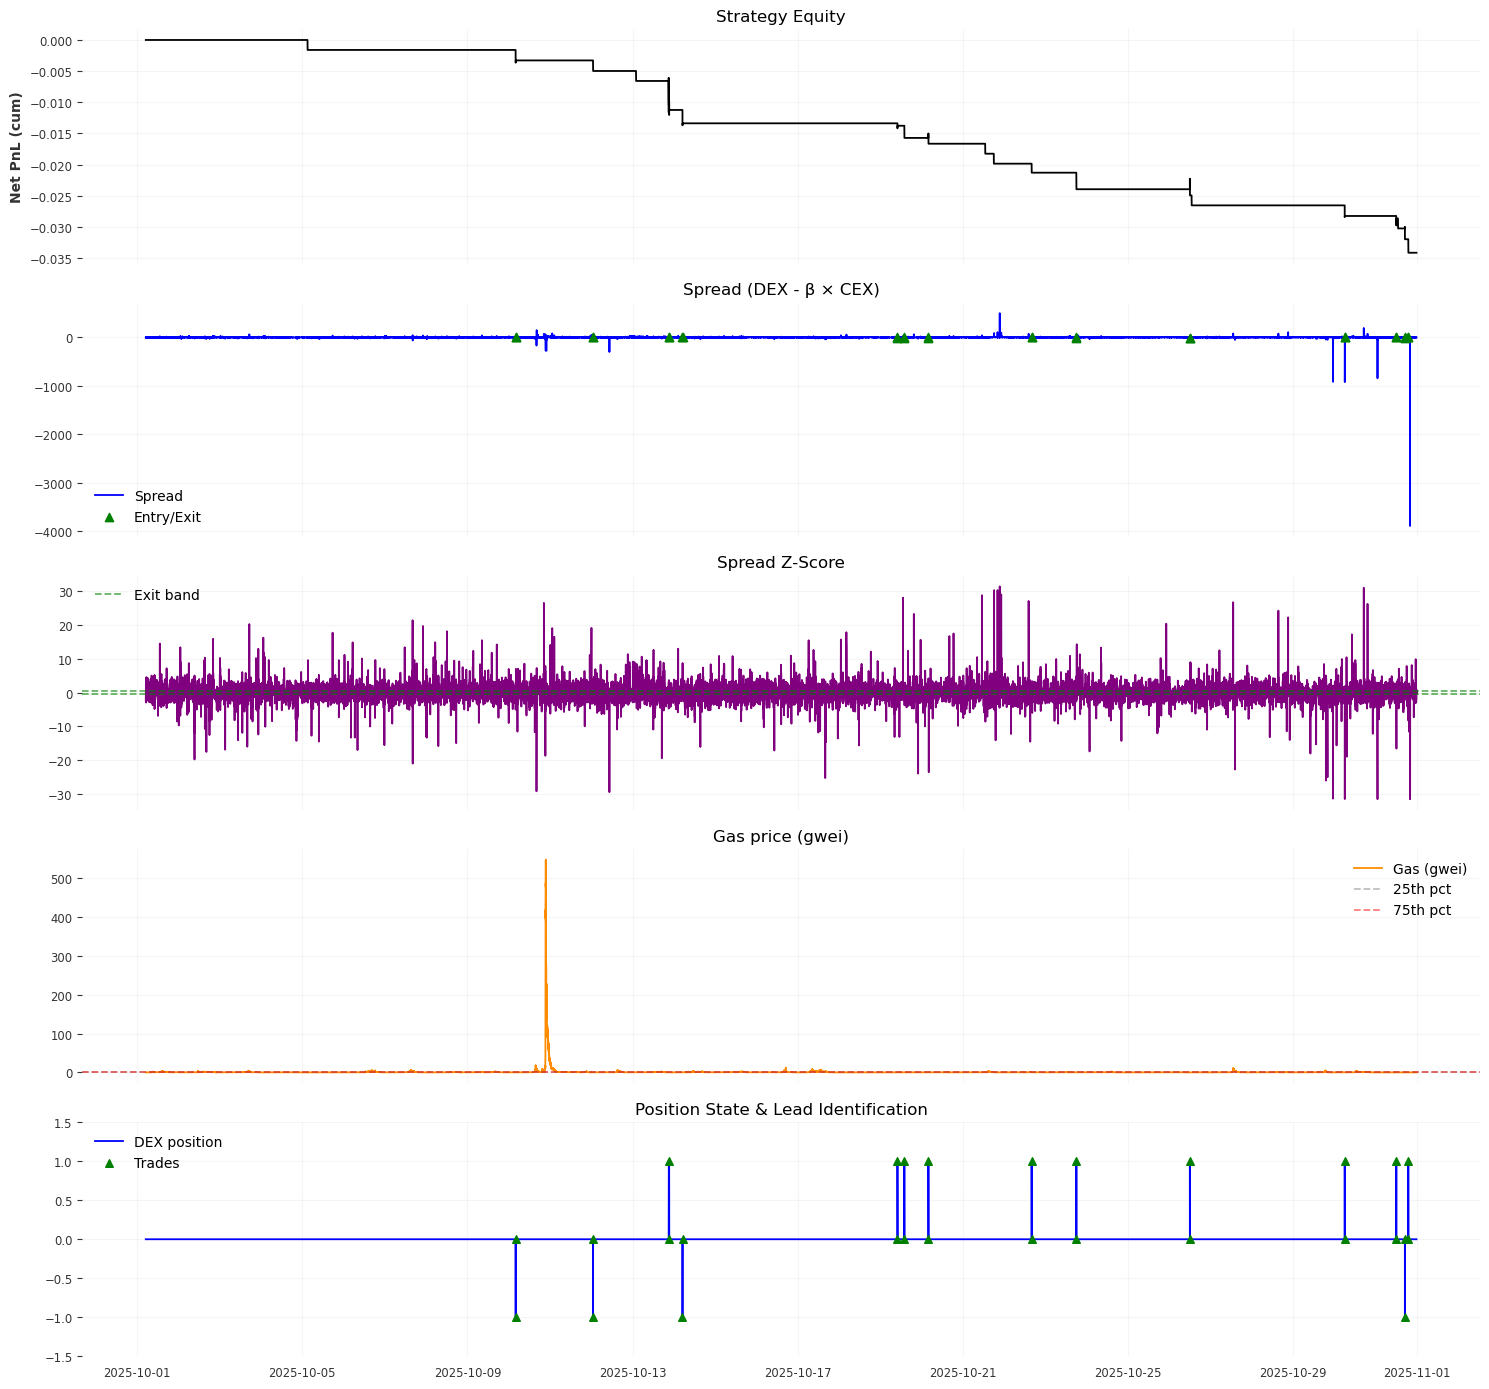

In [253]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1) Detect position columns
# ----------------------------
# Try common names used in your code
dex_candidates = ["pos_dex", "position_dex"]
cex_candidates = ["pos_cex", "position_cex"]

dex_col = None
cex_col = None

for c in dex_candidates:
    if c in df.columns:
        dex_col = c
        break

for c in cex_candidates:
    if c in df.columns:
        cex_col = c
        break

if dex_col is None:
    raise ValueError("Could not find a DEX position column (tried pos_dex / position_dex). "
                     "Use the df that comes out of the strategy backtest cell.")

# ----------------------------
# 2) Identify trades (entry/exit)
# ----------------------------
df['trade'] = df[dex_col].diff().fillna(0)
entry_idx = df.index[df['trade'] != 0]

# ----------------------------
# 3) Make the diagnostic plots
# ----------------------------
fig, axes = plt.subplots(5, 1, figsize=(15, 14), sharex=True)

# 1) Equity curve
axes[0].plot(df.index, df.get('equity', df.get('equity', df['pnl'].cumsum())),
             color='black')
axes[0].set_title("Strategy Equity")
axes[0].set_ylabel("Net PnL (cum)")
axes[0].grid(alpha=0.3)

# 2) Spread with trade markers
axes[1].plot(df.index, df['spread'], color='blue', label="Spread")
axes[1].scatter(entry_idx, df.loc[entry_idx, 'spread'],
                marker='^', color='green', label='Entry/Exit', zorder=3)
axes[1].set_title("Spread (DEX - β × CEX)")
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3) Z-score with exit bands
axes[2].plot(df.index, df['spread_z'], color='purple')
axes[2].axhline(0.5,  color='green', linestyle='--', alpha=0.6, label='Exit band')
axes[2].axhline(-0.5, color='green', linestyle='--', alpha=0.6)
axes[2].set_title("Spread Z-Score")
axes[2].legend()
axes[2].grid(alpha=0.3)

# 4) Gas price + low/med/high visual
axes[3].plot(df.index, df['base_fee_gwei'], color='darkorange', label='Gas (gwei)')
q25 = df['base_fee_gwei'].quantile(0.25)
q75 = df['base_fee_gwei'].quantile(0.75)
axes[3].axhline(q25, color='gray', linestyle='--', alpha=0.5, label='25th pct')
axes[3].axhline(q75, color='red', linestyle='--', alpha=0.5, label='75th pct')
axes[3].set_title("Gas price (gwei)")
axes[3].legend()
axes[3].grid(alpha=0.3)

# 5) Position + who leads (CEX vs DEX)
axes[4].plot(df.index, df[dex_col], color='blue', label="DEX position")

if cex_col is not None:
    axes[4].plot(df.index, df[cex_col], color='black', label="CEX position")

if 'leader' in df.columns:
    dex_leads = df['leader'] == 'DEX'
    cex_leads = df['leader'] == 'CEX'

    axes[4].fill_between(df.index, -1.2, 1.2, where=dex_leads,
                         color='blue', alpha=0.1, label='DEX leads')
    axes[4].fill_between(df.index, -1.2, 1.2, where=cex_leads,
                         color='orange', alpha=0.1, label='CEX leads')

axes[4].scatter(entry_idx, df.loc[entry_idx, dex_col],
                marker='^', color='green', s=30, label='Trades', zorder=3)

axes[4].set_ylim([-1.5, 1.5])
axes[4].set_title("Position State & Lead Identification")
axes[4].legend(loc="upper left")
axes[4].grid(alpha=0.3)

plt.tight_layout()
plt.show()
